In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import silhouette_score

In [ ]:
'''
dataframes used:
df: original pedestrian coordinate dataframe with frames
agg_df: has seconds column instead of frames
raw_data: entire platform_coordinates dataframe

'''

In [2]:
df = pd.read_csv('convertedFile.csv')
print(df.shape)

(18387281, 5)


In [ ]:
'''READING DATA'''

In [3]:
# Define correct headers
headers = ['id', 'frame', 'x', 'y', 'h']

# Set appropriate dtypes
dtypes = {
    'id': int,
    'frame': int,
    'x': float,
    'y': float,
    'h': float
}

# Load the file with no header, assign names
df = pd.read_csv('convertedFile.csv', header=None, names=headers, dtype=dtypes)

print(df.head())

        id  frame       x      y      h
0  9014102      0 -49.978  5.889  0.996
1  9014102      1 -49.978  5.889  1.005
2  9014102      2 -49.978  5.889  1.003
3  9014102      3 -50.001  5.864  1.014
4  9014102      4 -50.002  5.888  1.008


In [4]:
# Load your data
df = pd.read_csv('convertedFile.csv', header=None, names=['id', 'frame', 'x', 'y', 'h'], dtype={
    'id': int, 'frame': int, 'x': float, 'y': float, 'h': float
})

# Drop rows with any missing or invalid data
df = df.dropna()

# Create a new column for "second" by flooring frame/4
df['second'] = (df['frame'] // 4).astype(int)

# Group by id and second, aggregate by mean
agg_df = df.groupby(['id', 'second'], as_index=False)[['x', 'y', 'h']].mean()

# Optional: Save result
agg_df.to_csv('aggregated_per_second.csv', index=False)

# Preview result
print(agg_df.head())

        id  second         x        y        h
0  9014102       0 -49.98375  5.88275  1.00450
1  9014102       1 -49.98400  5.88875  0.99900
2  9014102       2 -49.99525  5.87025  1.01300
3  9014102       3 -49.99000  5.88850  0.99700
4  9014102       4 -49.99000  5.88850  0.99175


In [5]:
num_unique_ids = agg_df['id'].nunique()
print(f"Toatal number of people travelling in 22 hrs: {num_unique_ids}")

Toatal number of people travelling in 22 hrs: 81639


In [6]:
# Define a function to parse grouped coordinates
def extract_coords_by_label(data):
    coords_by_label = {}
    for row in data:
        x, y, label = row
        if label not in coords_by_label:
            coords_by_label[label] = {'x': [], 'y': []}
        coords_by_label[label]['x'].append(x)
        coords_by_label[label]['y'].append(y)
    return coords_by_label

# Raw coordinate data
raw_data = [
     (-21.19, 9.09, 'Stairs'), (-21.69, 9.45, 'Stairs'), (-22.31, 9.45, 'Stairs'),
    (-22.81, 9.09, 'Stairs'), (-23.0, 8.5, 'Stairs'), (-22.81, 7.91, 'Stairs'),
    (-22.31, 7.55, 'Stairs'), (-21.69, 7.55, 'Stairs'), (-21.19, 7.91, 'Stairs'),
    (-17.0, 8.3, 'Stairs'), (-13.74, 8.6, 'Stairs'), (-13.74, 2.2, 'Stairs'),
    (-17.0, 2.0, 'Stairs'), (-21.19, 2.39, 'Stairs'), (-21.69, 2.75, 'Stairs'),
    (-22.31, 2.75, 'Stairs'), (-22.81, 2.39, 'Stairs'), (-23.0, 1.8, 'Stairs'),
    (-22.81, 1.21, 'Stairs'), (-22.31, 0.85, 'Stairs'), (-21.69, 0.85, 'Stairs'),
    (-21.19, 1.21, 'Stairs'), (-17.0, 0.5, 'Stairs'), (-12.2, 2.0, 'Stairs'),
    (2.05, 2.05, 'Stairs'), (2.06, 8.74, 'Stairs'), (-12.6, 8.74, 'Stairs'),
    (-17.0, 10.3, 'Stairs'), (-21.19, 9.09, 'Stairs'),

    (-22, 5, 'Door'), (-22, 5.5, 'Door'), (-21.5, 5.5, 'Door'), (-21.5, 5, 'Door'), (-22, 5, 'Door'),

    (-30.36, 5.15, 'Pillar_1'), (-30.49, 5.55, 'Pillar_1'), (-30.83, 5.79, 'Pillar_1'), (-31.24, 5.79, 'Pillar_1'),
    (-31.58, 5.55, 'Pillar_1'), (-31.71, 5.15, 'Pillar_1'), (-31.58, 4.76, 'Pillar_1'), (-31.24, 4.51, 'Pillar_1'),
    (-30.83, 4.51, 'Pillar_1'), (-30.49, 4.76, 'Pillar_1'), (-30.36, 5.15, 'Pillar_1'),

    (-33.08, 5.30, 'Schedule'), (-33.08, 4.81, 'Schedule'), (-37.48, 4.81, 'Schedule'),
    (-37.48, 5.30, 'Schedule'), (-33.08, 5.30, 'Schedule'),

    (-39.27, 5.15, 'Pillar_2'), (-39.4, 5.55, 'Pillar_2'), (-39.73, 5.79, 'Pillar_2'), (-40.15, 5.79, 'Pillar_2'),
    (-40.48, 5.55, 'Pillar_2'), (-40.61, 5.15, 'Pillar_2'), (-40.48, 4.76, 'Pillar_2'), (-40.15, 4.51, 'Pillar_2'),
    (-39.73, 4.51, 'Pillar_2'), (-39.4, 4.76, 'Pillar_2'), (-39.27, 5.15, 'Pillar_2'),

    (-43.70, 5.73, 'Snack_Automat'), (-43.70, 4.32, 'Snack_Automat'), (-44.92, 4.32, 'Snack_Automat'),
    (-44.92, 5.73, 'Snack_Automat'), (-43.70, 5.73, 'Snack_Automat'),

    (-48.17, 5.03, 'Pillar_3'), (-48.3, 5.43, 'Pillar_3'), (-48.63, 5.67, 'Pillar_3'), (-49.05, 5.67, 'Pillar_3'),
    (-49.38, 5.43, 'Pillar_3'), (-49.51, 5.03, 'Pillar_3'), (-49.38, 4.64, 'Pillar_3'), (-49.05, 4.39, 'Pillar_3'),
    (-48.63, 4.39, 'Pillar_3'), (-48.3, 4.64, 'Pillar_3'), (-48.17, 5.03, 'Pillar_3'),

    (-53.59, 5.24, 'Display'), (-53.59, 4.50, 'Display'), (-53.96, 4.50, 'Display'),
    (-53.96, 5.24, 'Display'), (-53.59, 5.24, 'Display'),

    (-56.83, 4.97, 'Pillar_4'), (-56.96, 5.36, 'Pillar_4'), (-57.29, 5.61, 'Pillar_4'), (-57.71, 5.61, 'Pillar_4'),
    (-58.04, 5.36, 'Pillar_4'), (-58.17, 4.97, 'Pillar_4'), (-58.04, 4.57, 'Pillar_4'), (-57.71, 4.33, 'Pillar_4'),
    (-57.29, 4.33, 'Pillar_4'), (-56.96, 4.57, 'Pillar_4'), (-56.83, 4.97, 'Pillar_4'),

    (-62.50, 5.30, 'Trash can'), (-62.50, 4.63, 'Trash can'), (-62.20, 4.63, 'Trash can'),
    (-62.20, 5.30, 'Trash can'), (-62.50, 5.30, 'Trash can')
]

In [ ]:
'''MEASUREMENT LINE CREATION'''

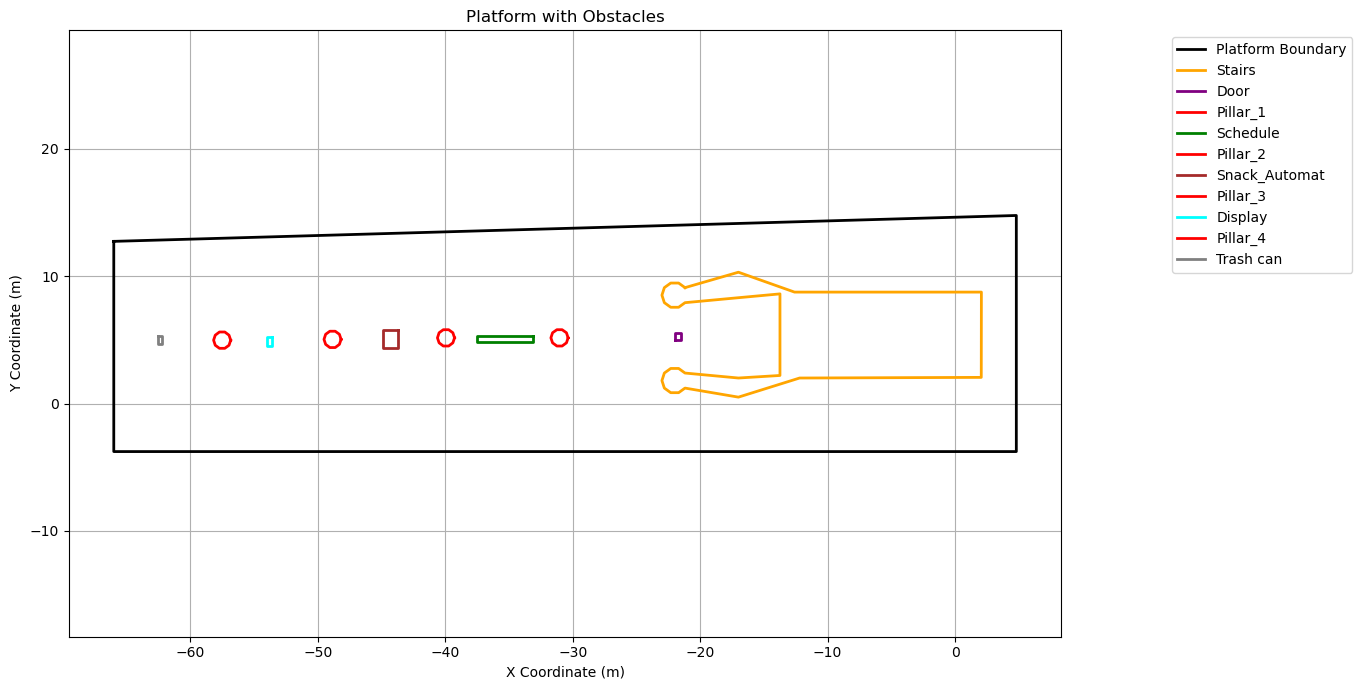

In [7]:
import matplotlib.pyplot as plt

# Platform boundaries
platform_x = [-66, -66, 4.80, 4.80, -66]
platform_y = [12.72, -3.77, -3.77, 14.75, 12.72]

# Parse the raw data
obstacles = extract_coords_by_label(raw_data)

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(platform_x, platform_y, 'k-', linewidth=2, label='Platform Boundary')

# Draw each obstacle
colors = {
    "Stairs": "orange",
    "Door": "purple",
    "Pillar_1": "red",
    "Pillar_2": "red",
    "Pillar_3": "red",
    "Pillar_4": "red",
    "Schedule": "green",
    "Snack_Automat": "brown",
    "Display": "cyan",
    "Trash can": "gray"
}

for label, coords in obstacles.items():
    plt.plot(coords['x'], coords['y'], color=colors.get(label, 'black'), linewidth=2, label=label)

# Plot formatting
plt.title('Platform with Obstacles')
plt.xlabel('X Coordinate (m)')
plt.ylabel('Y Coordinate (m)')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()


In [ ]:
'''
Measurement Line Coordinates Calculation:

Top measurement line:
12.72−2=10.72 → This is the upper measurement line.

Bottom measurement line:
−3.77+2=−1.77 → This is the lower measurement line.

Purpose:
These lines likely define a safe zone or active pedestrian measurement area that avoids edge effects near the platform boundaries.
Useful for accurate analysis of pedestrian flow, boarding/alighting activity, or obstacle interaction away from platform edges.

'''

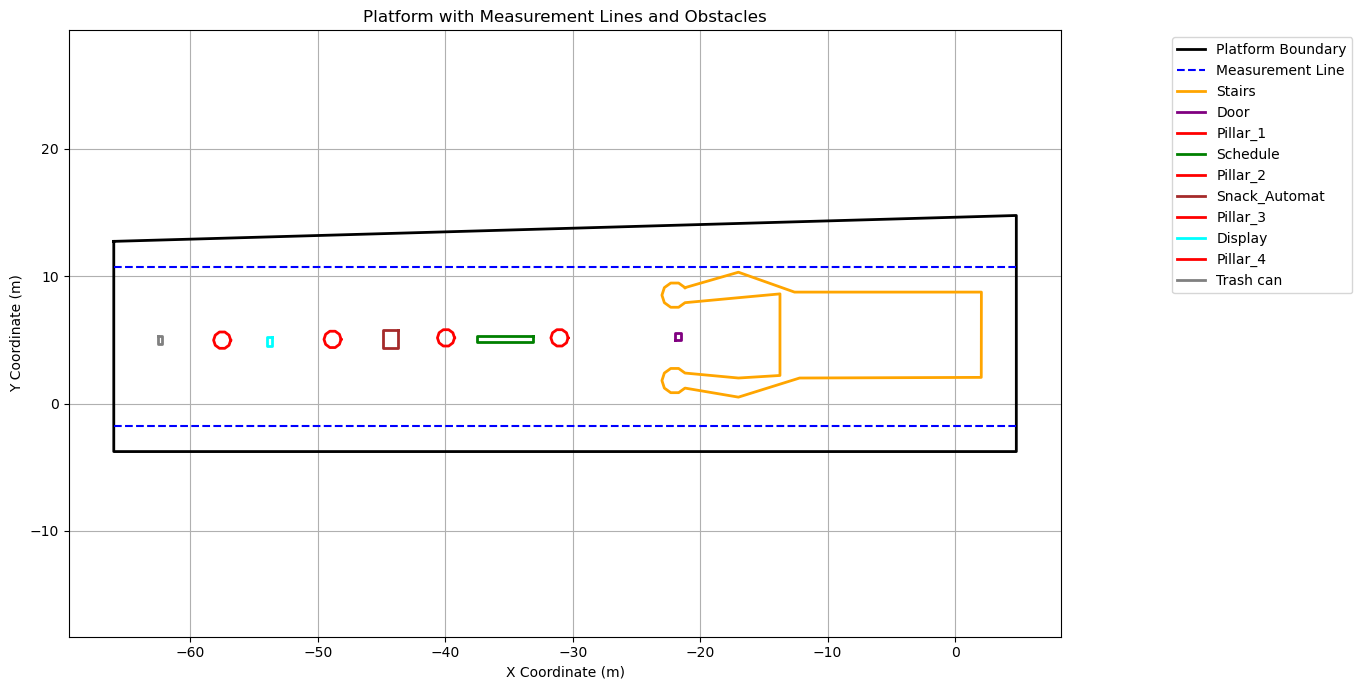

In [8]:
import matplotlib.pyplot as plt


# Platform boundaries
platform_x = [-66, -66, 4.80, 4.80, -66]
platform_y = [12.72, -3.77, -3.77, 14.75, 12.72]

# Horizontal measurement lines
horizontal_lines_y = [-1.77,10.72]
horizontal_line_x_start = -66
horizontal_line_x_end = 4.80

# Parse the raw data
obstacles = extract_coords_by_label(raw_data)

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(platform_x, platform_y, 'k-', linewidth=2, label='Platform Boundary')

# Draw horizontal measurement lines
for y in horizontal_lines_y:
    plt.plot([horizontal_line_x_start, horizontal_line_x_end], [y, y], 'b--', label='Measurement Line' if y == horizontal_lines_y[0] else "")

# Draw each obstacle
colors = {
    "Stairs": "orange",
    "Door": "purple",
    "Pillar_1": "red",
    "Pillar_2": "red",
    "Pillar_3": "red",
    "Pillar_4": "red",
    "Schedule": "green",
    "Snack_Automat": "brown",
    "Display": "cyan",
    "Trash can": "gray"
}

for label, coords in obstacles.items():
    plt.plot(coords['x'], coords['y'], color=colors.get(label, 'black'), linewidth=2, label=label)

# Plot formatting
plt.title('Platform with Measurement Lines and Obstacles')
plt.xlabel('X Coordinate (m)')
plt.ylabel('Y Coordinate (m)')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()

In [ ]:
'''
This code analyzes pedestrian density on a train platform over time. 
It filters the data to include only people within the platform boundaries, calculates the number of unique individuals 
present per second, smooths the count, and detects high-density moments using peak detection, then visualizes the results.

'''

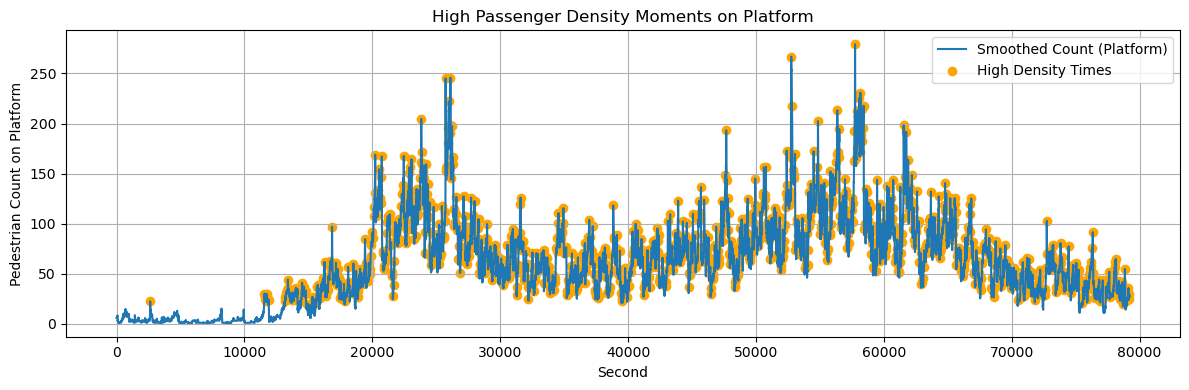

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Load cleaned aggregated data
agg_df = pd.read_csv("agg_df_cleaned.csv")

# Parameters
window_size = 30  # seconds
density_threshold_platform = 20  # adjust based on platform size/activity

# Define platform y-boundaries (example values — replace with actual platform bounds)
platform_y_bottom = -3.770     # min y of platform
platform_y_top = 14.750       # max y of platform

# Filter: Only pedestrians on the entire platform
platform_df = agg_df[
    (agg_df['y'] >= platform_y_bottom) &
    (agg_df['y'] <= platform_y_top)
]

# Count unique people on platform per second
platform_density_by_sec = platform_df.groupby('second')['id'].nunique().reset_index(name='count')

# Smooth the counts with rolling mean
platform_density_by_sec['smoothed'] = platform_density_by_sec['count'].rolling(window=5, center=True).mean()

# Detect peaks in total platform density
peaks_platform, _ = find_peaks(platform_density_by_sec['smoothed'].fillna(0), height=density_threshold_platform, distance=30)
high_density_seconds = platform_density_by_sec['second'].iloc[peaks_platform].tolist()

# Plot
plt.figure(figsize=(12, 4))
plt.plot(platform_density_by_sec['second'], platform_density_by_sec['smoothed'], label='Smoothed Count (Platform)')
plt.scatter(platform_density_by_sec['second'].iloc[peaks_platform],
            platform_density_by_sec['smoothed'].iloc[peaks_platform],
            color='orange', label='High Density Times')
plt.xlabel('Second')
plt.ylabel('Pedestrian Count on Platform')
plt.title('High Passenger Density Moments on Platform')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# print("High density moments (seconds):", high_density_seconds)


In [10]:
# Define platform bounds (replace with real values)
platform_y_bottom = -3.770     # min y of platform
platform_y_top = 14.750

# Filter for people on the platform
platform_df = agg_df[
    (agg_df['y'] >= platform_y_bottom) &
    (agg_df['y'] <= platform_y_top)
]

# Count unique people per second
density_by_sec = platform_df.groupby('second')['id'].nunique().reset_index(name='count')

# Find the second with the highest density
max_second = int(density_by_sec.loc[density_by_sec['count'].idxmax(), 'second'])

# Print result
print(f"Highest pedestrian density occurs at second: {max_second}")


Highest pedestrian density occurs at second: 57748


In [11]:
import pandas as pd

# Base start time
start_time = pd.Timestamp("2021-11-02 01:00:00")

# Convert 57748 seconds into timestamp
peak_time = start_time + pd.Timedelta(seconds=57748)

print("Peak second 57748 corresponds to:", peak_time)


Peak second 57748 corresponds to: 2021-11-02 17:02:28


In [12]:
# Filter the agg_df to the peak second
peak_second_df = agg_df[agg_df['second'] == 57748]

# Count unique IDs (i.e., people) present on the platform
num_passengers = peak_second_df['id'].nunique()

print(f"Number of passengers present on platform at 2021-11-02 17:02:28: {num_passengers}")


Number of passengers present on platform at 2021-11-02 17:02:28: 284


In [13]:
# Filter the agg_df to the peak second
peak_second_df = agg_df[agg_df['second'] == 57752]

# Count unique IDs (i.e., people) present on the platform
num_passengers = peak_second_df['id'].nunique()

print(f"Number of passengers present on platform at 2021-11-02 17:02:32: {num_passengers}")

Number of passengers present on platform at 2021-11-02 17:02:32: 268


In [14]:
import pandas as pd

# Add timestamp column
start_time = pd.Timestamp("2021-11-02 01:00:00")
agg_df['timestamp'] = agg_df['second'].apply(lambda s: start_time + pd.Timedelta(seconds=s))


In [15]:
cleaned_df= pd.read_csv('agg_df_cleaned.csv', dtype=dtypes)
print(cleaned_df.head())


        id  second         x        y        h            timestamp
0  9014102       0 -49.98375  5.88275  1.00450  2021-11-02 01:00:00
1  9014102       1 -49.98400  5.88875  0.99900  2021-11-02 01:00:01
2  9014102       2 -49.99525  5.87025  1.01300  2021-11-02 01:00:02
3  9014102       3 -49.99000  5.88850  0.99700  2021-11-02 01:00:03
4  9014102       4 -49.99000  5.88850  0.99175  2021-11-02 01:00:04


In [16]:
# Train arrives at this time
train_time = pd.Timestamp("2021-11-02 17:02:28")

# Start of 15-minute window
start_window = train_time - pd.Timedelta(minutes=15)

# People active during that 15-minute window
pre_window_df = agg_df[(agg_df['timestamp'] >= start_window) & (agg_df['timestamp'] < train_time)]

# Unique pedestrian IDs during that window
pre_window_ids = pre_window_df['id'].unique()
num_pre_window = len(pre_window_ids)

print(f"Number of people on the platform between {start_window.time()} and {train_time.time()}: {num_pre_window}")


Number of people on the platform between 16:47:28 and 17:02:28: 1804


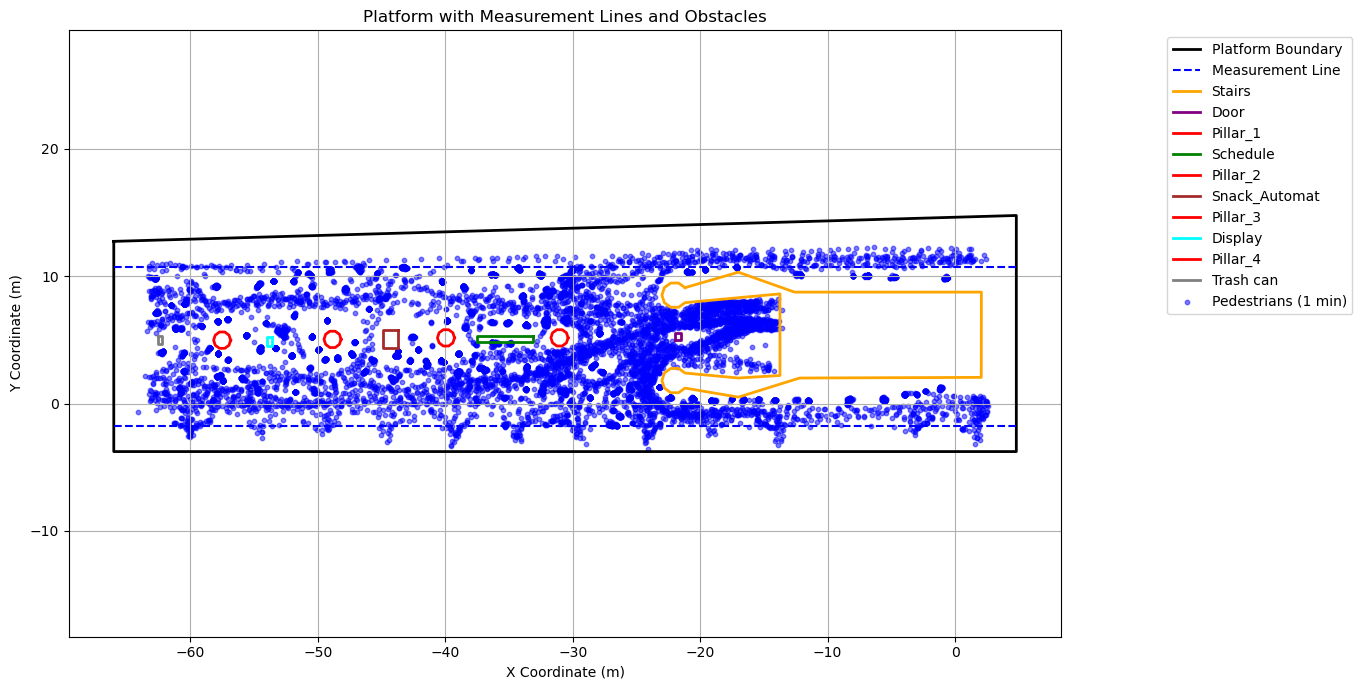

In [17]:
import matplotlib.pyplot as plt


# Platform boundaries
platform_x = [-66, -66, 4.80, 4.80, -66]
platform_y = [12.72, -3.77, -3.77, 14.75, 12.72]

# Horizontal measurement lines
horizontal_lines_y = [-1.77,10.72]
horizontal_line_x_start = -66
horizontal_line_x_end = 4.80

# Parse the raw data
obstacles = extract_coords_by_label(raw_data)

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(platform_x, platform_y, 'k-', linewidth=2, label='Platform Boundary')

# Draw horizontal measurement lines
for y in horizontal_lines_y:
    plt.plot([horizontal_line_x_start, horizontal_line_x_end], [y, y], 'b--', label='Measurement Line' if y == horizontal_lines_y[0] else "")

# Draw each obstacle
colors = {
    "Stairs": "orange",
    "Door": "purple",
    "Pillar_1": "red",
    "Pillar_2": "red",
    "Pillar_3": "red",
    "Pillar_4": "red",
    "Schedule": "green",
    "Snack_Automat": "brown",
    "Display": "cyan",
    "Trash can": "gray"
}

for label, coords in obstacles.items():
    plt.plot(coords['x'], coords['y'], color=colors.get(label, 'black'), linewidth=2, label=label)

    # --- Overlay pedestrian positions for 1-minute window ---
window_df = agg_df[(agg_df['second'] >= 57747) & (agg_df['second'] <= 57807)]

plt.scatter(window_df['x'], window_df['y'], s=10, c='blue', alpha=0.5, label='Pedestrians (1 min)')

# Plot formatting
plt.title('Platform with Measurement Lines and Obstacles')
plt.xlabel('X Coordinate (m)')
plt.ylabel('Y Coordinate (m)')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()


In [18]:
# Filter the data to the peak second
peak_second_df = agg_df[agg_df['second'] == 57748]

# Get unique pedestrian IDs present at that second
peak_passenger_ids = peak_second_df['id'].unique()

# Count them
num_passengers = len(peak_passenger_ids)

print(f"Number of passengers present at 2021-11-02 17:02:28: {num_passengers}")
print("Sample passenger IDs:", peak_passenger_ids[:10])  # show a few IDs


Number of passengers present at 2021-11-02 17:02:28: 284
Sample passenger IDs: [9107655 9108125 9108160 9108265 9108529 9108668 9108837 9108896 9109026
 9109032]


In [ ]:
'''

This code identifies pedestrians who were present during a peak second (57748) and analyzes their full trajectories to determine who crossed the upper (y = 10.72) or lower (y = -1.77) measurement lines. 
It infers boarding and alighting behavior based on the direction of crossing: boarding if they move from inside the platform toward outside, and alighting if they move in the opposite direction. 
Finally, it outputs the counts of such directional crossings.

'''

In [19]:
import pandas as pd

# Load data
agg_df = pd.read_csv("agg_df_cleaned.csv")

# Peak second
peak_second = 57748

# Get IDs present at the peak second
peak_ids = agg_df[agg_df['second'] == peak_second]['id'].unique()

# Get full trajectory for those IDs
peak_trajectories = agg_df[agg_df['id'].isin(peak_ids)]

# Group by pedestrian ID and get their start & end y-coordinates
trajectory_summary = peak_trajectories.groupby('id').agg(start_y=('y', 'first'), end_y=('y', 'last'))

# Boarding logic
boarding_upper = trajectory_summary[(trajectory_summary['start_y'] < 10.72) & (trajectory_summary['end_y'] > 10.72)]
boarding_lower = trajectory_summary[(trajectory_summary['start_y'] > -1.77) & (trajectory_summary['end_y'] < -1.77)]

# Alighting logic
alighting_upper = trajectory_summary[(trajectory_summary['start_y'] > 10.72) & (trajectory_summary['end_y'] < 10.72)]
alighting_lower = trajectory_summary[(trajectory_summary['start_y'] < -1.77) & (trajectory_summary['end_y'] > -1.77)]

# Output counts
print("Boarding:")
print(f"  Upper Line Crossings (↑): {len(boarding_upper)}")
print(f"  Lower Line Crossings (↓): {len(boarding_lower)}")

print("\nAlighting:")
print(f"  Upper Line Crossings (↓): {len(alighting_upper)}")
print(f"  Lower Line Crossings (↑): {len(alighting_lower)}")


Boarding:
  Upper Line Crossings (↑): 27
  Lower Line Crossings (↓): 90

Alighting:
  Upper Line Crossings (↓): 14
  Lower Line Crossings (↑): 64


In [20]:
# Define a ±30 second window around the peak second
window_size = 30
window_start = peak_second - window_size
window_end = peak_second + window_size

# Filter the data to include only records within this window
window_df = agg_df[(agg_df['second'] >= window_start) & (agg_df['second'] <= window_end)].copy()

print(f"Analyzing data from second {window_start} to {window_end}")
print(f"Number of unique pedestrian IDs in window: {window_df['id'].nunique()}")


Analyzing data from second 57718 to 57778
Number of unique pedestrian IDs in window: 487


In [ ]:
'''

This code analyzes pedestrian trajectories within a 60-second window around a peak second (57748) to identify individuals who crossed the upper (y = 10.72) or lower (y = -1.77) platform boundaries. 
It detects crossing points and classifies each pedestrian as boarding or alighting based on the direction of their movement. 
The final output shows how many people boarded or alighted across each boundary line.

'''

In [21]:
import pandas as pd
import numpy as np

# Load data
agg_df = pd.read_csv("agg_df_cleaned.csv")

# Peak second and window
peak_second = 57748
window_size = 30
window_start = peak_second - window_size
window_end = peak_second + window_size

# Filter relevant pedestrians
peak_ids = agg_df[(agg_df['second'] >= window_start) & (agg_df['second'] <= window_end)]['id'].unique()
peak_trajectories = agg_df[agg_df['id'].isin(peak_ids)].sort_values(['id', 'second'])

# Helper to detect crossing and get x
def find_crossing_point(pid, df, line_y, action, margin=2):
    person = df[df['id'] == pid].sort_values('second')
    prev = None
    crossing_time, x_cross = None, None

    for _, row in person.iterrows():
        if prev is not None:
            y1, y2 = prev['y'], row['y']
            if (y1 - line_y) * (y2 - line_y) < 0:
                t = (line_y - y1) / (y2 - y1)
                x_cross = prev['x'] + t * (row['x'] - prev['x'])
                crossing_sec = prev['second'] + t * (row['second'] - prev['second'])
                crossing_time = int(crossing_sec)
                break
        prev = row

    if not crossing_time:
        return None

    if action == "Boarding":
        approach = person[person['second'] < crossing_time]
        approach = approach[abs(approach['y'] - line_y) > margin]
        if not approach.empty:
            return pid, x_cross
    elif action == "Alighting":
        dispersal = person[person['second'] > crossing_time]
        dispersal = dispersal[abs(dispersal['y'] - line_y) > margin]
        if not dispersal.empty:
            return pid, x_cross
    return None

# Group by pedestrian to get start and end y
trajectory_summary = peak_trajectories.groupby('id').agg(
    start_y=('y', 'first'),
    end_y=('y', 'last')
)

# Identify crossing candidates
boarding_upper_ids = trajectory_summary[(trajectory_summary['start_y'] < 10.72) & (trajectory_summary['end_y'] > 10.72)].index
boarding_lower_ids = trajectory_summary[(trajectory_summary['start_y'] > -1.77) & (trajectory_summary['end_y'] < -1.77)].index
alighting_upper_ids = trajectory_summary[(trajectory_summary['start_y'] > 10.72) & (trajectory_summary['end_y'] < 10.72)].index
alighting_lower_ids = trajectory_summary[(trajectory_summary['start_y'] < -1.77) & (trajectory_summary['end_y'] > -1.77)].index

# Collect valid (pid, x) pairs
boarding_upper = [find_crossing_point(pid, agg_df, 10.72, "Boarding") for pid in boarding_upper_ids]
boarding_lower = [find_crossing_point(pid, agg_df, -1.77, "Boarding") for pid in boarding_lower_ids]
alighting_upper = [find_crossing_point(pid, agg_df, 10.72, "Alighting") for pid in alighting_upper_ids]
alighting_lower = [find_crossing_point(pid, agg_df, -1.77, "Alighting") for pid in alighting_lower_ids]

# Filter valid results
boarding_upper = [r for r in boarding_upper if r]
boarding_lower = [r for r in boarding_lower if r]
alighting_upper = [r for r in alighting_upper if r]
alighting_lower = [r for r in alighting_lower if r]

# Output counts
print("Boarding:")
print(f"  Upper Line Crossings (↑): {len(boarding_upper)}")
print(f"  Lower Line Crossings (↓): {len(boarding_lower)}")

print("\nAlighting:")
print(f"  Upper Line Crossings (↓): {len(alighting_upper)}")
print(f"  Lower Line Crossings (↑): {len(alighting_lower)}")


Boarding:
  Upper Line Crossings (↑): 33
  Lower Line Crossings (↓): 96

Alighting:
  Upper Line Crossings (↓): 13
  Lower Line Crossings (↑): 62


In [22]:
print("Boarding:")
print(f"  Upper Line Crossings (↑): {len(boarding_upper)}")
print("  IDs:", [pid for pid, _ in boarding_upper])

print(f"  Lower Line Crossings (↓): {len(boarding_lower)}")
print("  IDs:", [pid for pid, _ in boarding_lower])

print("\nAlighting:")
print(f"  Upper Line Crossings (↓): {len(alighting_upper)}")
print("  IDs:", [pid for pid, _ in alighting_upper])

print(f"  Lower Line Crossings (↑): {len(alighting_lower)}")
print("  IDs:", [pid for pid, _ in alighting_lower])


Boarding:
  Upper Line Crossings (↑): 33
  IDs: [9110113, 9110348, 9110420, 9110482, 9110566, 9110624, 9110809, 9110817, 9110876, 9110962, 9110972, 9111067, 9111200, 9111219, 9111278, 9111292, 9111320, 9111324, 9111379, 9111463, 9111484, 9111502, 9111561, 9111591, 9111686, 9111773, 9111829, 9111965, 9112013, 9112018, 9113092, 9113195, 9113236]
  Lower Line Crossings (↓): 96
  IDs: [9107655, 9108125, 9108265, 9108529, 9108668, 9108837, 9108896, 9109026, 9109032, 9109283, 9109321, 9109764, 9109794, 9109816, 9109825, 9109849, 9109859, 9109913, 9109949, 9109999, 9110084, 9110092, 9110095, 9110190, 9110247, 9110253, 9110285, 9110317, 9110320, 9110339, 9110352, 9110373, 9110390, 9110391, 9110392, 9110486, 9110524, 9110548, 9110638, 9110647, 9110658, 9110698, 9110701, 9110804, 9110848, 9110904, 9110916, 9110920, 9110960, 9110977, 9110987, 9110996, 9111014, 9111025, 9111026, 9111042, 9111043, 9111064, 9111068, 9111079, 9111082, 9111107, 9111127, 9111133, 9111140, 9111147, 9111199, 9111235, 911

In [ ]:
'''UPPER LINE BOARDING PASSENGER'''

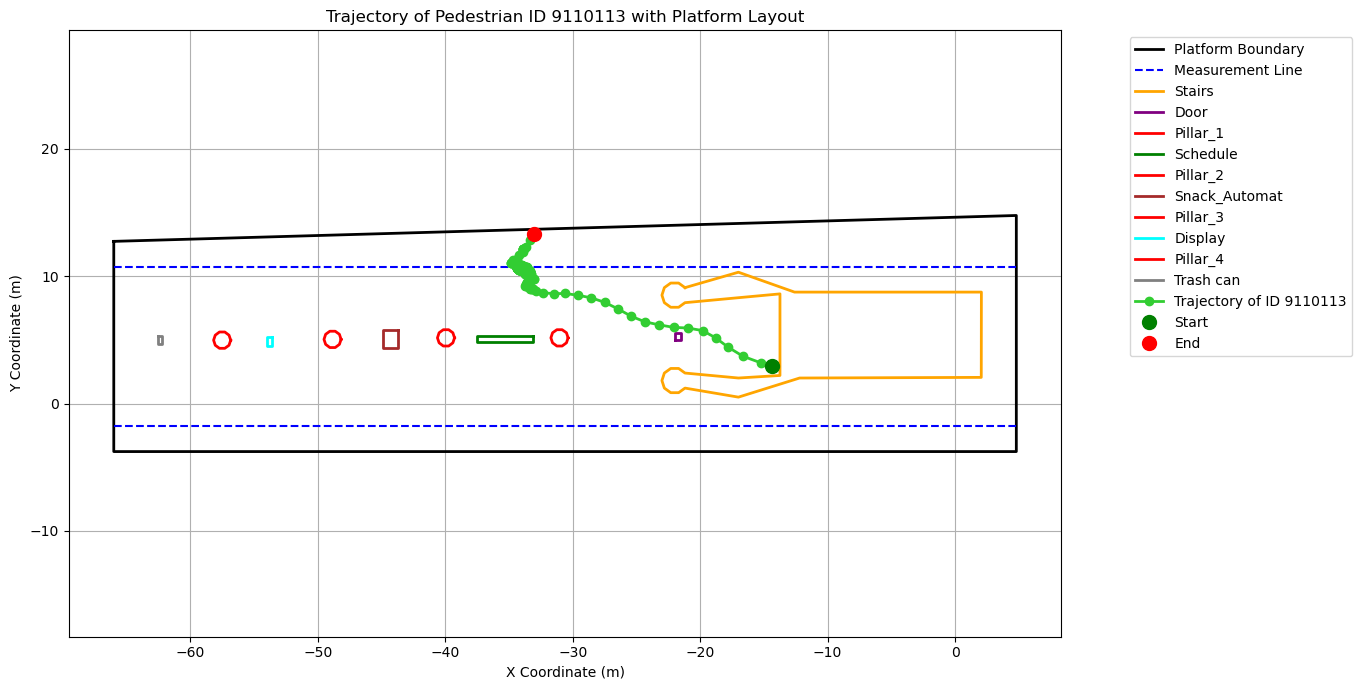

In [23]:

obstacles = extract_coords_by_label(raw_data)

# STEP 3: Plotting platform layout and person trajectory
platform_x = [-66, -66, 4.80, 4.80, -66]
platform_y = [12.72, -3.77, -3.77, 14.75, 12.72]
horizontal_lines_y = [-1.77, 10.72]
horizontal_line_x_start = -66
horizontal_line_x_end = 4.80

# Select ID
person_id = 9110113
person_df = agg_df[agg_df['id'] == person_id].sort_values('second')

# Plot
plt.figure(figsize=(14, 7))
plt.plot(platform_x, platform_y, 'k-', linewidth=2, label='Platform Boundary')

for y in horizontal_lines_y:
    plt.plot([horizontal_line_x_start, horizontal_line_x_end], [y, y], 'b--', label='Measurement Line' if y == horizontal_lines_y[0] else "")

colors = {
    "Stairs": "orange", "Door": "purple", "Pillar_1": "red", "Pillar_2": "red",
    "Pillar_3": "red", "Pillar_4": "red", "Schedule": "green", "Snack_Automat": "brown",
    "Display": "cyan", "Trash can": "gray"
}

for label, coords in obstacles.items():
    plt.plot(coords['x'], coords['y'], color=colors.get(label, 'black'), linewidth=2, label=label)

plt.plot(person_df['x'], person_df['y'], color='limegreen', linewidth=2, marker='o', label=f'Trajectory of ID {person_id}')
if not person_df.empty:
    plt.plot(person_df.iloc[0]['x'], person_df.iloc[0]['y'], 'go', markersize=10, label='Start')
    plt.plot(person_df.iloc[-1]['x'], person_df.iloc[-1]['y'], 'ro', markersize=10, label='End')

plt.title(f'Trajectory of Pedestrian ID {person_id} with Platform Layout')
plt.xlabel('X Coordinate (m)')
plt.ylabel('Y Coordinate (m)')
plt.axis('equal')
plt.grid(True)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
plt.tight_layout()
plt.show()


In [ ]:
'''LOWER LINE ALIGHTING PASSENGER'''

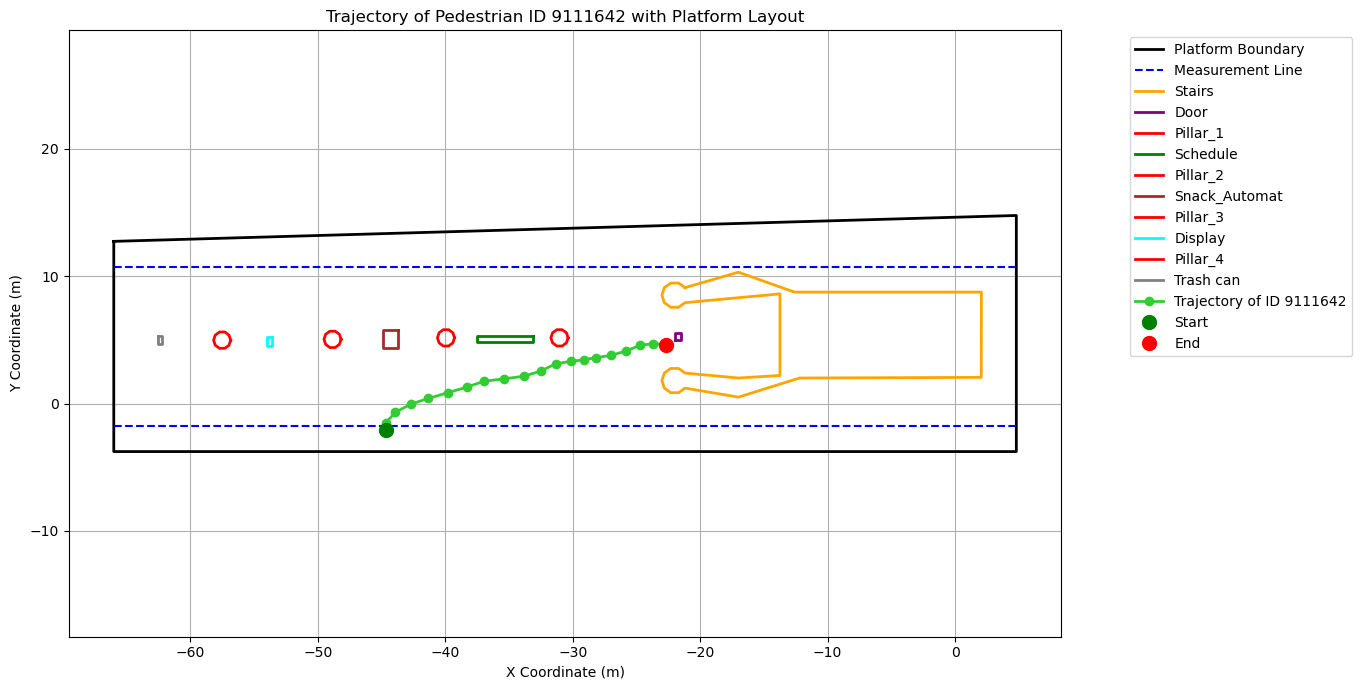

In [24]:

obstacles = extract_coords_by_label(raw_data)

# STEP 3: Plotting platform layout and person trajectory
platform_x = [-66, -66, 4.80, 4.80, -66]
platform_y = [12.72, -3.77, -3.77, 14.75, 12.72]
horizontal_lines_y = [-1.77, 10.72]
horizontal_line_x_start = -66
horizontal_line_x_end = 4.80

# Select ID
person_id = 9111642
person_df = agg_df[agg_df['id'] == person_id].sort_values('second')

# Plot
plt.figure(figsize=(14, 7))
plt.plot(platform_x, platform_y, 'k-', linewidth=2, label='Platform Boundary')

for y in horizontal_lines_y:
    plt.plot([horizontal_line_x_start, horizontal_line_x_end], [y, y], 'b--', label='Measurement Line' if y == horizontal_lines_y[0] else "")

colors = {
    "Stairs": "orange", "Door": "purple", "Pillar_1": "red", "Pillar_2": "red",
    "Pillar_3": "red", "Pillar_4": "red", "Schedule": "green", "Snack_Automat": "brown",
    "Display": "cyan", "Trash can": "gray"
}

for label, coords in obstacles.items():
    plt.plot(coords['x'], coords['y'], color=colors.get(label, 'black'), linewidth=2, label=label)

plt.plot(person_df['x'], person_df['y'], color='limegreen', linewidth=2, marker='o', label=f'Trajectory of ID {person_id}')
if not person_df.empty:
    plt.plot(person_df.iloc[0]['x'], person_df.iloc[0]['y'], 'go', markersize=10, label='Start')
    plt.plot(person_df.iloc[-1]['x'], person_df.iloc[-1]['y'], 'ro', markersize=10, label='End')

plt.title(f'Trajectory of Pedestrian ID {person_id} with Platform Layout')
plt.xlabel('X Coordinate (m)')
plt.ylabel('Y Coordinate (m)')
plt.axis('equal')
plt.grid(True)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
plt.tight_layout()
plt.show()


In [ ]:
'''

This code performs KMeans clustering on the X-coordinates where pedestrians crossed the upper and lower platform edges, aiming to identify likely train door positions. 
It uses the elbow and silhouette methods to determine the optimal number of clusters (k) for each edge, then visualizes the clustered crossing points and their centers. 
The final output lists the estimated door locations along both edges based on these clusters.

'''

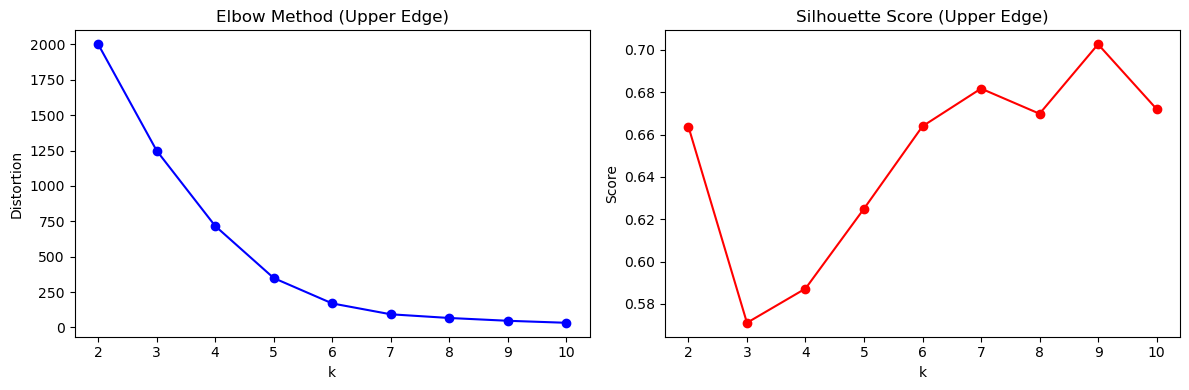

Optimal k for Upper Edge: 9 (Silhouette Score = 0.703)


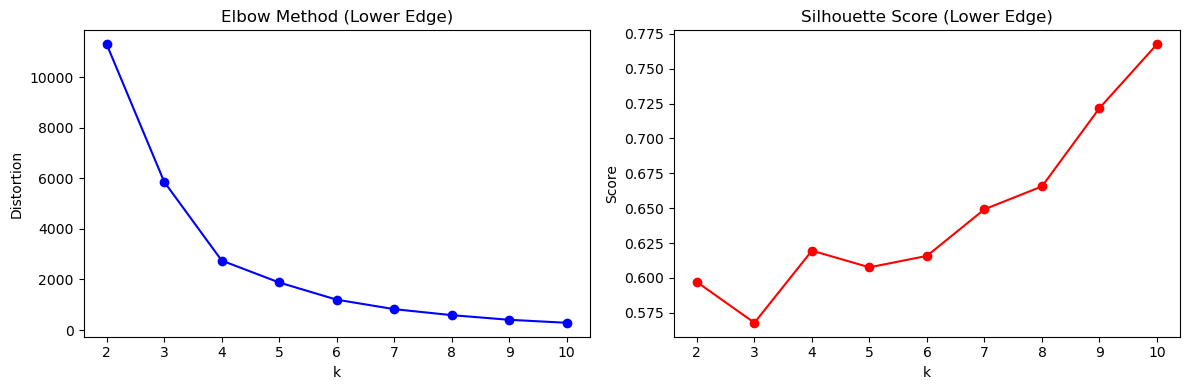

Optimal k for Lower Edge: 10 (Silhouette Score = 0.767)


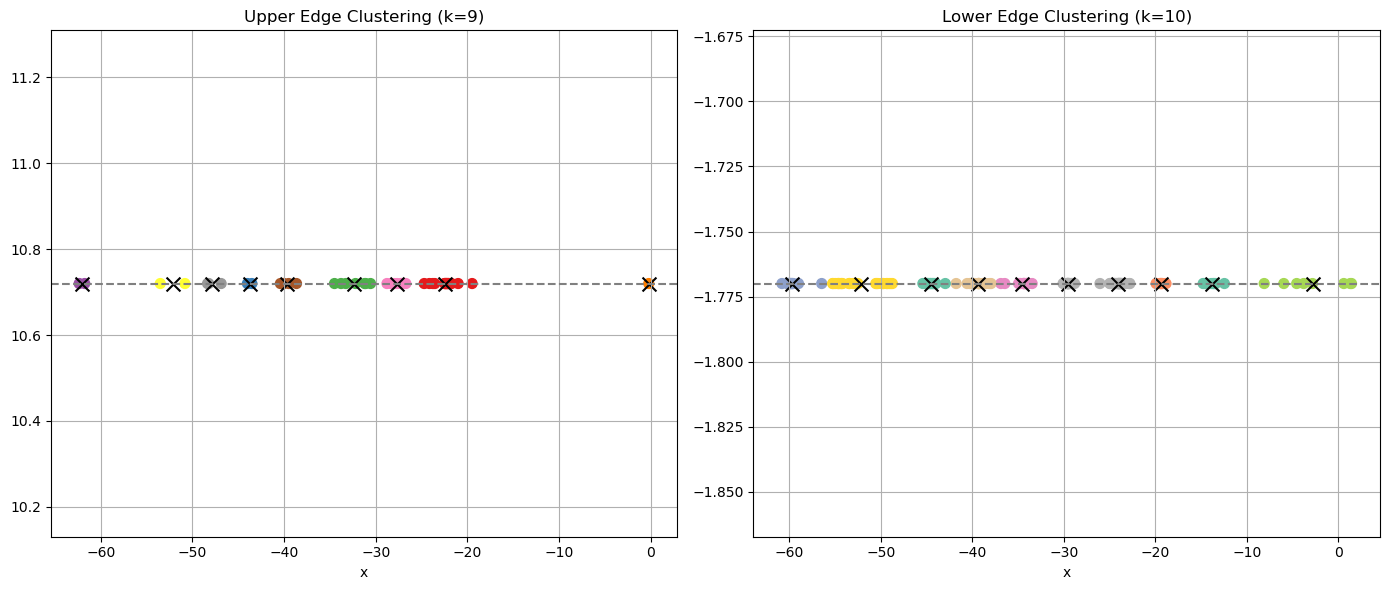


Final Cluster Centers:
Upper Edge (y=10.72): [-62.05507813 -52.16588132 -47.81879948 -43.76092612 -39.73819382
 -32.37928171 -27.69662349 -22.40139857  -0.21668478]
Lower Edge (y=-1.77): [-59.69764163 -52.12659193 -44.49779789 -39.42350542 -34.54646536
 -29.51358199 -24.04544797 -19.35465458 -13.81123929  -2.72053576]


In [25]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Step 1: Combine x-coordinates by edge
upper_x = np.array([x for _, x in boarding_upper + alighting_upper]).reshape(-1, 1)
lower_x = np.array([x for _, x in boarding_lower + alighting_lower]).reshape(-1, 1)

# Step 2: KMeans helper
def determine_k(data, label):
    if len(data) < 2:
        print(f"Not enough data for {label}")
        return 1
    
    distortions, silhouettes = [], []
    K = range(2, min(10, len(data)) + 1)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42).fit(data)
        distortions.append(kmeans.inertia_)
        silhouettes.append(silhouette_score(data, kmeans.labels_))

    # Plot elbow & silhouette
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(K, distortions, 'bo-')
    plt.title(f"Elbow Method ({label})")
    plt.xlabel("k")
    plt.ylabel("Distortion")

    plt.subplot(1, 2, 2)
    plt.plot(K, silhouettes, 'ro-')
    plt.title(f"Silhouette Score ({label})")
    plt.xlabel("k")
    plt.ylabel("Score")

    plt.tight_layout()
    plt.show()

    best_k = K[np.argmax(silhouettes)]
    print(f"Optimal k for {label}: {best_k} (Silhouette Score = {max(silhouettes):.3f})")
    return best_k

# Step 3: Find optimal k and cluster
best_k_upper = determine_k(upper_x, "Upper Edge")
best_k_lower = determine_k(lower_x, "Lower Edge")

kmeans_upper = KMeans(n_clusters=best_k_upper, random_state=42).fit(upper_x)
kmeans_lower = KMeans(n_clusters=best_k_lower, random_state=42).fit(lower_x)

# Step 4: Plot results
plt.figure(figsize=(14, 6))

# Upper
plt.subplot(1, 2, 1)
plt.scatter(upper_x, [10.72]*len(upper_x), c=kmeans_upper.labels_, cmap='Set1', s=50)
plt.scatter(kmeans_upper.cluster_centers_, [10.72]*best_k_upper, c='black', marker='x', s=100)
plt.axhline(y=10.72, color='gray', linestyle='--')
plt.title(f"Upper Edge Clustering (k={best_k_upper})")
plt.xlabel("x")
plt.grid(True)

# Lower
plt.subplot(1, 2, 2)
plt.scatter(lower_x, [-1.77]*len(lower_x), c=kmeans_lower.labels_, cmap='Set2', s=50)
plt.scatter(kmeans_lower.cluster_centers_, [-1.77]*best_k_lower, c='black', marker='x', s=100)
plt.axhline(y=-1.77, color='gray', linestyle='--')
plt.title(f"Lower Edge Clustering (k={best_k_lower})")
plt.xlabel("x")
plt.grid(True)

plt.tight_layout()
plt.show()

# Step 5: Print cluster centers
print("\nFinal Cluster Centers:")
print(f"Upper Edge (y=10.72): {np.sort(kmeans_upper.cluster_centers_.flatten())}")
print(f"Lower Edge (y=-1.77): {np.sort(kmeans_lower.cluster_centers_.flatten())}")


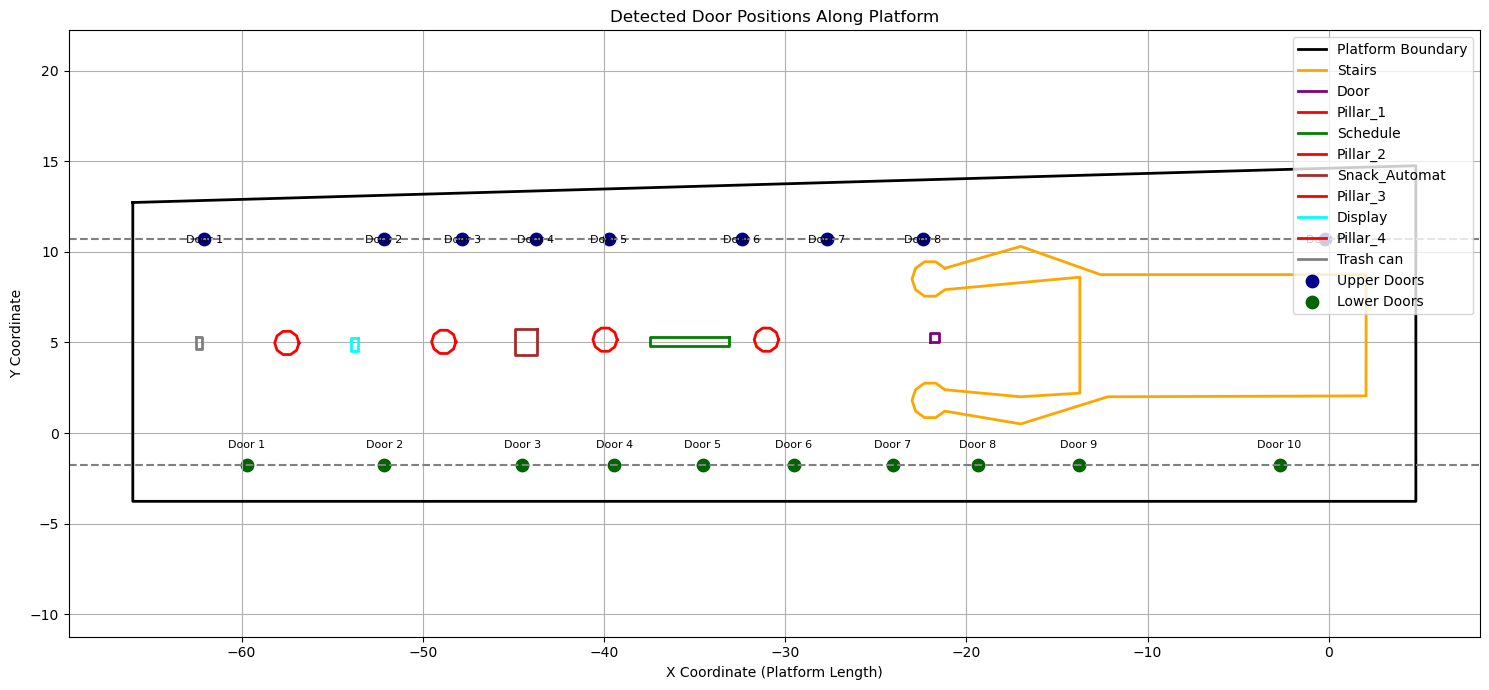

In [26]:

# Final door X positions 
upper_doors = np.array([-62.05507813, -52.16588132, -47.81879948, -43.76092612 ,-39.73819382,
 -32.37928171 ,-27.69662349, -22.40139857,  -0.21668478])
lower_doors = np.array([-59.69764163, -52.12659193, -44.49779789, -39.42350542, -34.54646536,
 -29.51358199 ,-24.04544797 ,-19.35465458, -13.81123929,  -2.72053576])

obstacles = extract_coords_by_label(raw_data)

# Plot
plt.figure(figsize=(15, 7))

# Platform
platform_x = [-66, -66, 4.8, 4.8, -66]
platform_y = [12.72, -3.77, -3.77, 14.75, 12.72]
plt.plot(platform_x, platform_y, 'k-', linewidth=2, label='Platform Boundary')

# Measurement lines
plt.axhline(y=-1.77, linestyle='--', color='gray')
plt.axhline(y=10.72, linestyle='--', color='gray')

# Obstacles
colors = {
    "Stairs": "orange",
    "Door": "purple",
    "Pillar_1": "red",
    "Pillar_2": "red",
    "Pillar_3": "red",
    "Pillar_4": "red",
    "Schedule": "green",
    "Snack_Automat": "brown",
    "Display": "cyan",
    "Trash can": "gray"
}

for label, coords in obstacles.items():
    plt.plot(coords['x'], coords['y'], color=colors.get(label, 'black'), linewidth=2, label=label)

# Plot doors
plt.scatter(upper_doors, [10.72]*len(upper_doors), color='darkblue', s=80, label='Upper Doors')
plt.scatter(lower_doors, [-1.77]*len(lower_doors), color='darkgreen', s=80, label='Lower Doors')

# Label doors
for i, x in enumerate(upper_doors):
    plt.text(x, 10.4, f'Door {i+1}', ha='center', va='bottom', fontsize=8, color='black')
for i, x in enumerate(lower_doors):
    plt.text(x, -0.4, f'Door {i+1}', ha='center', va='top', fontsize=8, color='black')

# Final formatting
plt.title("Detected Door Positions Along Platform")
plt.xlabel("X Coordinate (Platform Length)")
plt.ylabel("Y Coordinate")
plt.axis('equal')
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


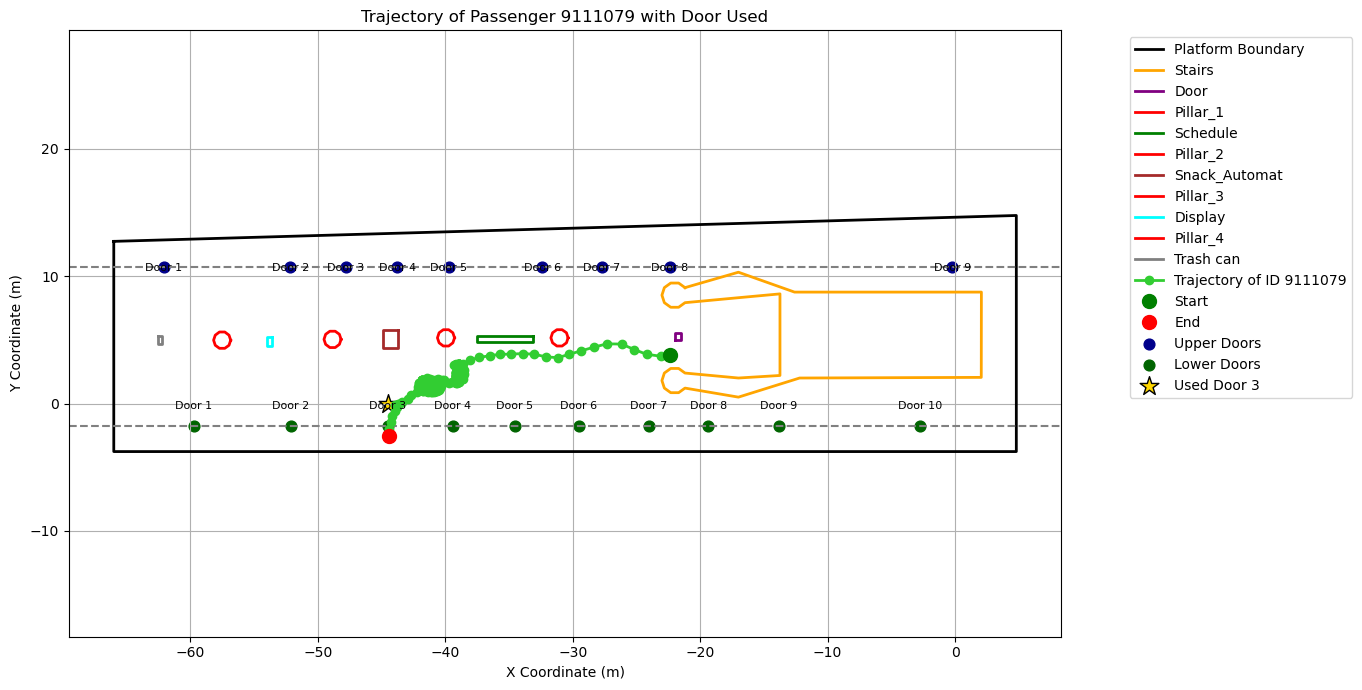

In [27]:
obstacles = extract_coords_by_label(raw_data)

# STEP 3: Door clusters
# Final door X positions 
upper_doors = np.array([-62.05507813, -52.16588132, -47.81879948, -43.76092612 ,-39.73819382,
 -32.37928171 ,-27.69662349, -22.40139857,  -0.21668478])
lower_doors = np.array([-59.69764163, -52.12659193, -44.49779789, -39.42350542, -34.54646536,
 -29.51358199 ,-24.04544797 ,-19.35465458, -13.81123929,  -2.72053576])



# STEP 4: Find the passenger's crossing point
person_id = 9111079
person_df = agg_df[agg_df['id'] == person_id].sort_values('second')

def get_crossing_x(df, line_y):
    prev = None
    for _, row in df.iterrows():
        if prev is not None:
            y1, y2 = prev['y'], row['y']
            if (y1 - line_y) * (y2 - line_y) < 0:
                t = (line_y - y1) / (y2 - y1)
                x_cross = prev['x'] + t * (row['x'] - prev['x'])
                return x_cross, line_y
        prev = row
    return None, None

# Detect which edge was crossed
x_cross, y_cross = get_crossing_x(person_df, 0)
if x_cross is None:
    x_cross, y_cross = get_crossing_x(person_df, 10)
    door_edge = 'upper'
else:
    door_edge = 'lower'

# Match to nearest clustered door
door_used = None
if x_cross is not None:
    if door_edge == 'upper':
        door_array = upper_doors
        y_label = 10
    else:
        door_array = lower_doors
        y_label = 0
    door_index = np.argmin(np.abs(door_array - x_cross))
    door_used = (door_array[door_index], y_label, f'Door {door_index + 1}')

# STEP 5: Plot
plt.figure(figsize=(14, 7))
platform_x = [-66, -66, 4.80, 4.80, -66]
platform_y = [12.72, -3.77, -3.77, 14.75, 12.72]
plt.plot(platform_x, platform_y, 'k-', linewidth=2, label='Platform Boundary')

# Measurement lines
plt.axhline(y=-1.77, color='gray', linestyle='--')
plt.axhline(y=10.72, color='gray', linestyle='--')

# Obstacles
colors = {
    "Stairs": "orange", "Door": "purple", "Pillar_1": "red", "Pillar_2": "red",
    "Pillar_3": "red", "Pillar_4": "red", "Schedule": "green", "Snack_Automat": "brown",
    "Display": "cyan", "Trash can": "gray"
}
for label, coords in obstacles.items():
    plt.plot(coords['x'], coords['y'], color=colors.get(label, 'black'), linewidth=2, label=label)

# Person trajectory
plt.plot(person_df['x'], person_df['y'], color='limegreen', linewidth=2, marker='o', label=f'Trajectory of ID {person_id}')
plt.plot(person_df.iloc[0]['x'], person_df.iloc[0]['y'], 'go', markersize=10, label='Start')
plt.plot(person_df.iloc[-1]['x'], person_df.iloc[-1]['y'], 'ro', markersize=10, label='End')

# Plot all doors
plt.scatter(upper_doors, [10.72]*9, c='darkblue', s=60, label='Upper Doors')
plt.scatter(lower_doors, [-1.77]*10, c='darkgreen', s=60, label='Lower Doors')

# Highlight used door
if door_used:
    plt.scatter(door_used[0], door_used[1], c='gold', edgecolors='black', s=200, label=f'Used {door_used[2]}', marker='*')

# Labels
for i, x in enumerate(upper_doors):
    plt.text(x, 10.4, f'Door {i+1}', ha='center', fontsize=8)
for i, x in enumerate(lower_doors):
    plt.text(x, -0.4, f'Door {i+1}', ha='center', fontsize=8)

# Final styling
plt.title(f'Trajectory of Passenger {person_id} with Door Used')
plt.xlabel('X Coordinate (m)')
plt.ylabel('Y Coordinate (m)')
plt.axis('equal')
plt.grid(True)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.tight_layout()
plt.show()


In [ ]:
'''

This code analyzes pedestrian trajectories around a peak second to estimate boarding and alighting durations per train door, using predefined door x-coordinates along the upper and lower platform edges. 
For each detected crossing, it calculates the time spent approaching (boarding) or dispersing (alighting) and assigns the crossing to the closest door. 
It then summarizes the number of events and total durations for each door in tabular form.

'''

In [28]:
import pandas as pd
import numpy as np

# Load data
agg_df = pd.read_csv("agg_df_cleaned.csv")

# Peak second (given/fixed)
peak_second = 57748

# Define ±30 second window
window_size = 30
window_start = peak_second - window_size
window_end = peak_second + window_size

# Get IDs present in the time window
peak_ids = agg_df[(agg_df['second'] >= window_start) & (agg_df['second'] <= window_end)]['id'].unique()

# Get full trajectory for those IDs
peak_trajectories = agg_df[agg_df['id'].isin(peak_ids)].sort_values(['id', 'second'])

# Define door x-coordinates
upper_doors = np.array([-62.05507813, -52.16588132, -47.81879948, -43.76092612 ,-39.73819382,
 -32.37928171 ,-27.69662349, -22.40139857,  -0.21668478])
lower_doors = np.array([-59.69764163, -52.12659193, -44.49779789, -39.42350542, -34.54646536,
 -29.51358199 ,-24.04544797 ,-19.35465458, -13.81123929,  -2.72053576])


# assign closest door
def assign_door(x_cross, doors):
    return int(np.argmin(np.abs(doors - x_cross))) + 1

# find crossing and duration
def find_crossing_duration(pid, df, line_y, action, margin=2):
    person = df[df['id'] == pid].sort_values('second')
    prev = None
    crossing_time, x_cross = None, None

    for _, row in person.iterrows():
        if prev is not None:
            y1, y2 = prev['y'], row['y']
            if (y1 - line_y) * (y2 - line_y) < 0:
                t = (line_y - y1) / (y2 - y1)
                x_cross = prev['x'] + t * (row['x'] - prev['x'])
                crossing_sec = prev['second'] + t * (row['second'] - prev['second'])
                crossing_time = int(crossing_sec)
                break
        prev = row

    if not crossing_time:
        return None

    if action == "Boarding":
        approach = person[person['second'] < crossing_time]
        approach = approach[abs(approach['y'] - line_y) > margin]
        if not approach.empty:
            start_sec = approach['second'].iloc[-1]
            return int(crossing_time - start_sec), x_cross
    elif action == "Alighting":
        dispersal = person[person['second'] > crossing_time]
        dispersal = dispersal[abs(dispersal['y'] - line_y) > margin]
        if not dispersal.empty:
            end_sec = dispersal['second'].iloc[0]
            return int(end_sec - crossing_time), x_cross
    return None

# Group by pedestrian ID and get their start & end y-coordinates
trajectory_summary = peak_trajectories.groupby('id').agg(
    start_y=('y', 'first'),
    end_y=('y', 'last')
)

# Boarding logic (IDs only)
boarding_upper_ids = trajectory_summary[
    (trajectory_summary['start_y'] < 10.72) & (trajectory_summary['end_y'] > 10.72)
].index
boarding_lower_ids = trajectory_summary[
    (trajectory_summary['start_y'] > -1.77) & (trajectory_summary['end_y'] < -1.77)
].index

# Alighting logic (IDs only)
alighting_upper_ids = trajectory_summary[
    (trajectory_summary['start_y'] > 10.72) & (trajectory_summary['end_y'] < 10.72)
].index
alighting_lower_ids = trajectory_summary[
    (trajectory_summary['start_y'] < -1.77) & (trajectory_summary['end_y'] > -1.77)
].index

# Collect durations and door crossings
def collect_durations(ids, y_line, action, doors, prefix):
    results = []
    for pid in ids:
        result = find_crossing_duration(pid, agg_df, y_line, action)
        if result:
            duration, x = result
            door_num = assign_door(x, doors)
            results.append((f"{prefix} Door {door_num}", duration))
    return results

boarding_upper_data = collect_durations(boarding_upper_ids, 10.72, "Boarding", upper_doors, "Upper")
boarding_lower_data = collect_durations(boarding_lower_ids, -1.77, "Boarding", lower_doors, "Lower")
alighting_upper_data = collect_durations(alighting_upper_ids, 10.72, "Alighting", upper_doors, "Upper")
alighting_lower_data = collect_durations(alighting_lower_ids, -1.77, "Alighting", lower_doors, "Lower")

# Build summary tables (with total duration)
def build_table(data):
    df = pd.DataFrame(data, columns=["Door", "Duration (s)"])
    summary = df.groupby("Door")["Duration (s)"].agg(['count', 'sum']).reset_index()
    summary.columns = ["Door", "Count", "Total Duration (s)"]
    summary["Total Duration (s)"] = summary["Total Duration (s)"].astype(int)
    return summary.sort_values("Door")

# Final summary tables
table_bu = build_table(boarding_upper_data)
table_bl = build_table(boarding_lower_data)
table_au = build_table(alighting_upper_data)
table_al = build_table(alighting_lower_data)

# Output counts
print("Boarding:")
print(f"  Upper Line Crossings (↑): {len(boarding_upper_data)}")
print(f"  Lower Line Crossings (↓): {len(boarding_lower_data)}")

print("\nAlighting:")
print(f"  Upper Line Crossings (↓): {len(alighting_upper_data)}")
print(f"  Lower Line Crossings (↑): {len(alighting_lower_data)}")

# Optional: print summary tables
print("\n Upper Edge – Boarding:")
print(table_bu.to_string(index=False))

print("\n Upper Edge – Alighting:")
print(table_au.to_string(index=False))

print("\n Lower Edge – Boarding:")
print(table_bl.to_string(index=False))

print("\n Lower Edge – Alighting:")
print(table_al.to_string(index=False))


Boarding:
  Upper Line Crossings (↑): 33
  Lower Line Crossings (↓): 96

Alighting:
  Upper Line Crossings (↓): 13
  Lower Line Crossings (↑): 62

 Upper Edge – Boarding:
        Door  Count  Total Duration (s)
Upper Door 1      2                 138
Upper Door 2      2                  23
Upper Door 3      3                  97
Upper Door 4      2                 122
Upper Door 5      4                 818
Upper Door 6      5                 285
Upper Door 7      5                  20
Upper Door 8     10                 426

 Upper Edge – Alighting:
        Door  Count  Total Duration (s)
Upper Door 5      1                   7
Upper Door 6      2                  17
Upper Door 7      2                  23
Upper Door 8      7                  31
Upper Door 9      1                  32

 Lower Edge – Boarding:
         Door  Count  Total Duration (s)
 Lower Door 1      8                 119
Lower Door 10      4                  49
 Lower Door 2     21                 760
 Lower Door 3 

IDs who boarded at Upper Door 5: [9110482, 9111278, 9111561, 9111686]


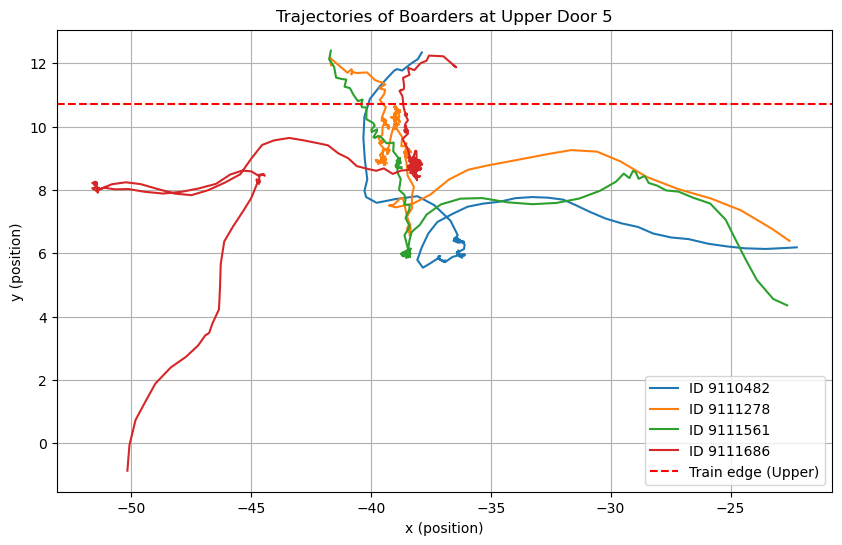

In [29]:
# Collect IDs of people assigned to Upper Door 5
door5_ids = []

for pid, x_cross in boarding_upper:
    door_num = assign_door(x_cross, upper_doors)
    if door_num == 5:
        door5_ids.append(pid)

print("IDs who boarded at Upper Door 5:", door5_ids)

# Plot their trajectories
plt.figure(figsize=(10, 6))
for pid in door5_ids:
    person_traj = agg_df[agg_df['id'] == pid]
    plt.plot(person_traj['x'], person_traj['y'], label=f"ID {pid}")

plt.axhline(10.72, color='red', linestyle='--', label='Train edge (Upper)')
plt.title("Trajectories of Boarders at Upper Door 5")
plt.xlabel("x (position)")
plt.ylabel("y (position)")
plt.legend()
plt.grid(True)
plt.show()


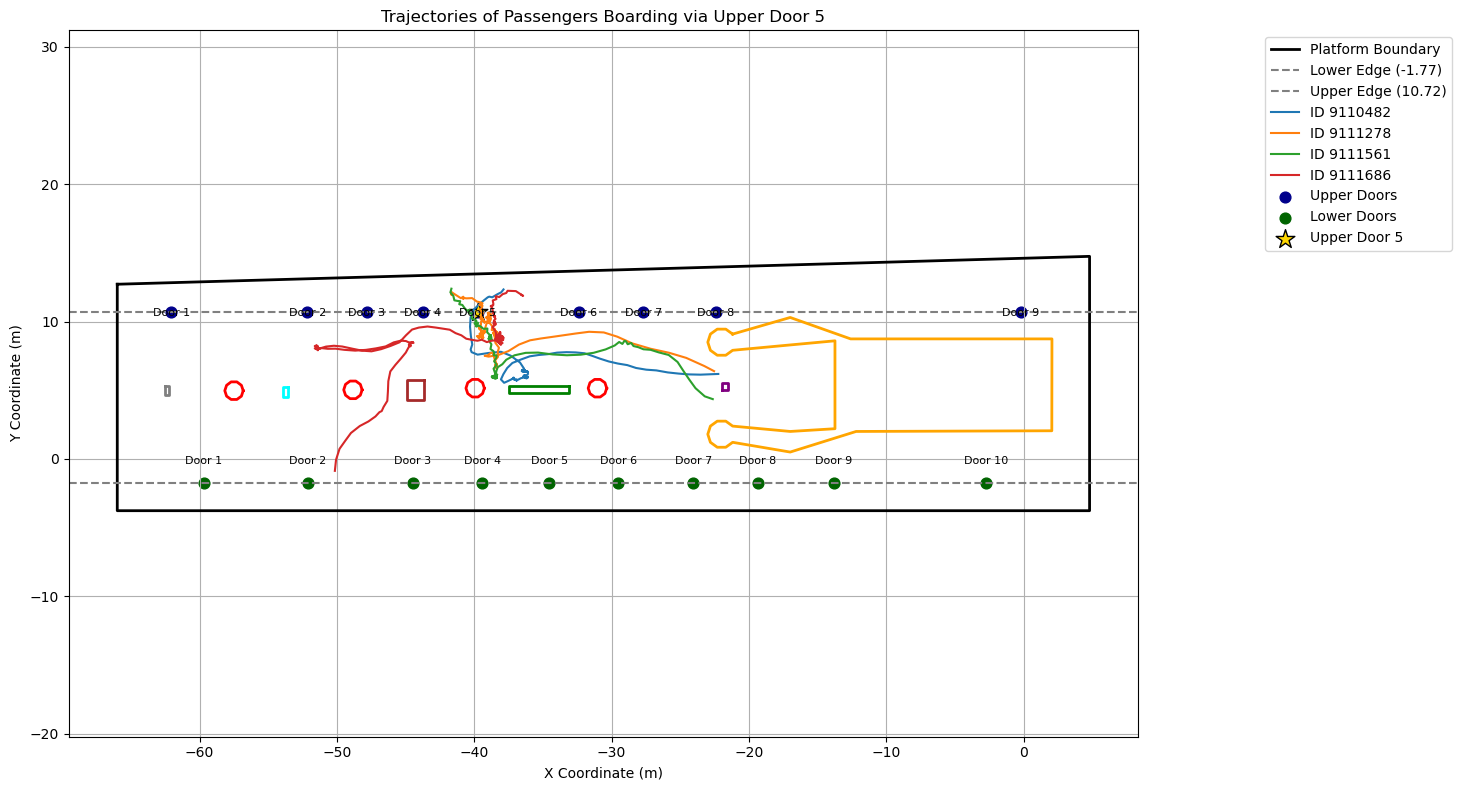

In [30]:
# STEP 4: Door 5 IDs (already defined)
# door5_ids = [9110482, 9111278, 9111561, 9111686]

# STEP 5: Combined Plot for Upper Door 5
plt.figure(figsize=(15, 8))

# Platform outline
platform_x = [-66, -66, 4.80, 4.80, -66]
platform_y = [12.72, -3.77, -3.77, 14.75, 12.72]
plt.plot(platform_x, platform_y, 'k-', linewidth=2, label='Platform Boundary')

# Measurement lines
plt.axhline(y=-1.77, color='gray', linestyle='--', label='Lower Edge (-1.77)')
plt.axhline(y=10.72, color='gray', linestyle='--', label='Upper Edge (10.72)')

# Obstacles
colors = {
    "Stairs": "orange", "Door": "purple", "Pillar_1": "red", "Pillar_2": "red",
    "Pillar_3": "red", "Pillar_4": "red", "Schedule": "green", "Snack_Automat": "brown",
    "Display": "cyan", "Trash can": "gray"
}
for label, coords in obstacles.items():
    plt.plot(coords['x'], coords['y'], color=colors.get(label, 'black'), linewidth=2)

# Trajectories of Door 5 boarders
for pid in door5_ids:
    person_traj = agg_df[agg_df['id'] == pid]
    plt.plot(person_traj['x'], person_traj['y'], label=f"ID {pid}")

# Door markers
plt.scatter(upper_doors, [10.72]*len(upper_doors), c='darkblue', s=60, label='Upper Doors')
plt.scatter(lower_doors, [-1.77]*len(lower_doors), c='darkgreen', s=60, label='Lower Doors')

# Highlight Upper Door 5 (index 4)
door5_x = upper_doors[4]
plt.scatter(door5_x, 10.72, c='gold', edgecolors='black', s=200, marker='*', label='Upper Door 5')

# Door labels
for i, x in enumerate(upper_doors):
    plt.text(x, 10.4, f'Door {i+1}', ha='center', fontsize=8)
for i, x in enumerate(lower_doors):
    plt.text(x, -0.4, f'Door {i+1}', ha='center', fontsize=8)

# Styling
plt.title('Trajectories of Passengers Boarding via Upper Door 5')
plt.xlabel('X Coordinate (m)')
plt.ylabel('Y Coordinate (m)')
plt.axis('equal')
plt.grid(True)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.tight_layout()
plt.show()


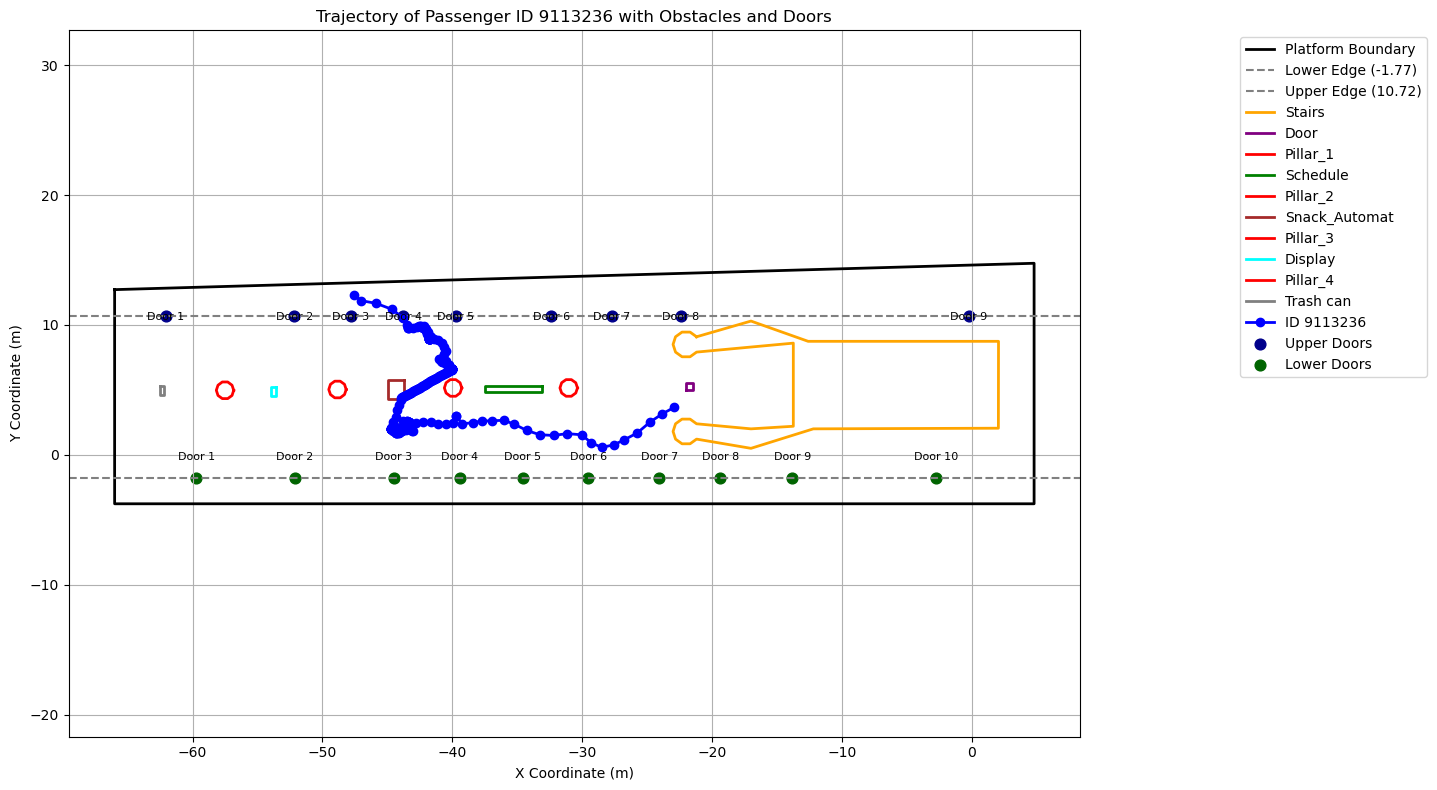

In [50]:
import matplotlib.pyplot as plt

# Target ID
pid = 9113236

# Extract trajectory
person_traj = agg_df[agg_df['id'] == pid]

# Start the plot
plt.figure(figsize=(15, 8))

# --- Platform outline
platform_x = [-66, -66, 4.80, 4.80, -66]
platform_y = [12.72, -3.77, -3.77, 14.75, 12.72]
plt.plot(platform_x, platform_y, 'k-', linewidth=2, label='Platform Boundary')

# --- Measurement lines (train edge)
plt.axhline(y=-1.77, color='gray', linestyle='--', label='Lower Edge (-1.77)')
plt.axhline(y=10.72, color='gray', linestyle='--', label='Upper Edge (10.72)')

# --- Obstacles (require 'obstacles' dictionary)
colors = {
    "Stairs": "orange", "Door": "purple", "Pillar_1": "red", "Pillar_2": "red",
    "Pillar_3": "red", "Pillar_4": "red", "Schedule": "green", "Snack_Automat": "brown",
    "Display": "cyan", "Trash can": "gray"
}
for label, coords in obstacles.items():
    plt.plot(coords['x'], coords['y'], color=colors.get(label, 'black'), linewidth=2, label=label)

# --- Person trajectory
plt.plot(person_traj['x'], person_traj['y'], color='blue', marker='o', label=f"ID {pid}", linewidth=2)

# --- Door markers
plt.scatter(upper_doors, [10.72]*len(upper_doors), c='darkblue', s=60, label='Upper Doors')
plt.scatter(lower_doors, [-1.77]*len(lower_doors), c='darkgreen', s=60, label='Lower Doors')

# --- Door labels
for i, x in enumerate(upper_doors):
    plt.text(x, 10.4, f'Door {i+1}', ha='center', fontsize=8)
for i, x in enumerate(lower_doors):
    plt.text(x, -0.4, f'Door {i+1}', ha='center', fontsize=8)

# --- Plot style
plt.title(f"Trajectory of Passenger ID {pid} with Obstacles and Doors")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Y Coordinate (m)")
plt.axis('equal')
plt.grid(True)
plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1))
plt.tight_layout()
plt.show()


IDs who boarded at Lower Door 7: [9109794, 9109999, 9110253, 9110320, 9111014, 9111243, 9111264, 9111346, 9111371, 9111401, 9111420, 9111539, 9111747, 9111766]


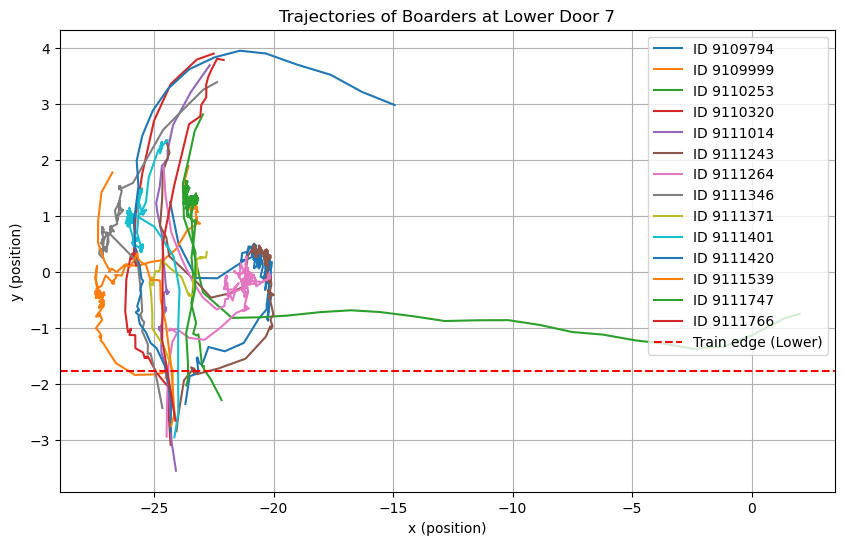

In [31]:
# Collect IDs of people assigned to Lower Door 7
door7_ids = []

for pid, x_cross in boarding_lower:
    door_num = assign_door(x_cross, lower_doors)
    if door_num == 7:
        door7_ids.append(pid)

print("IDs who boarded at Lower Door 7:", door7_ids)

# Plot their trajectories
plt.figure(figsize=(10, 6))
for pid in door7_ids:
    person_traj = agg_df[agg_df['id'] == pid]
    plt.plot(person_traj['x'], person_traj['y'], label=f"ID {pid}")

plt.axhline(-1.77, color='red', linestyle='--', label='Train edge (Lower)')
plt.title("Trajectories of Boarders at Lower Door 7")
plt.xlabel("x (position)")
plt.ylabel("y (position)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
'''

This code summarizes boarding and alighting activity at each train door by counting the number of events and calculating the time range (start/end) for each door. 
It separately processes upper and lower platform edges and combines them into a final summary table with boarding/alighting counts and total interaction time per door. 
The output gives a clear overview of passenger flow for each train door.
It finds:
The last person to board (latest boarding time)
The first person to alight (earliest alighting time)
Then it calculates:
The difference between these two events to estimate the busy time near that door
'''

In [54]:
import pandas as pd

# Helper to get counts and time info
def summarize_events(data, is_boarding=True):
    df = pd.DataFrame(data, columns=["Door", "Duration (s)"])
    
    count_summary = df.groupby("Door").size().reset_index(
        name="Boarding_Count" if is_boarding else "Alighting_Count"
    )
    time_summary = (
        df.groupby("Door")["Duration (s)"].max().reset_index(name="Boarding End Time")
        if is_boarding else
        df.groupby("Door")["Duration (s)"].min().reset_index(name="Alighting Start Time")
    )
    
    return pd.merge(count_summary, time_summary, on="Door")

# Build consistent table
def build_combined_table(boarding_data, alighting_data, train_label):
    board = summarize_events(boarding_data, is_boarding=True)
    alight = summarize_events(alighting_data, is_boarding=False)

    # Merge and handle missing data
    combined = pd.merge(board, alight, on="Door", how="outer").fillna(0)
    combined["Boarding_Count"] = combined["Boarding_Count"].astype(int)
    combined["Alighting_Count"] = combined["Alighting_Count"].astype(int)
    combined["Boarding End Time"] = combined["Boarding End Time"].astype(int)
    combined["Alighting Start Time"] = combined["Alighting Start Time"].astype(int)

    # Compute time, handle missing data
    def compute_time(row):
        if row["Boarding End Time"] > 0 and row["Alighting Start Time"] > 0:
            return row["Boarding End Time"] - row["Alighting Start Time"]
        elif row["Boarding End Time"] > 0:
            return row["Boarding End Time"]
        elif row["Alighting Start Time"] > 0:
            return row["Alighting Start Time"]
        else:
            return 0

    combined["Time"] = combined.apply(compute_time, axis=1).abs()
    combined["Train"] = train_label

    return combined[["Train", "Door", "Boarding_Count", "Alighting_Count", "Time"]].sort_values("Door")

# Combine both edges
upper_combined = build_combined_table(boarding_upper_data, alighting_upper_data, "Upper")
lower_combined = build_combined_table(boarding_lower_data, alighting_lower_data, "Lower")

final_combined_table = pd.concat([upper_combined, lower_combined], ignore_index=True)

# Display result
print("\nCombined Door Summary:")
print(final_combined_table.to_string(index=False))



Combined Door Summary:
Train          Door  Boarding_Count  Alighting_Count  Time
Upper  Upper Door 1               2                0   135
Upper  Upper Door 2               2                0    17
Upper  Upper Door 3               3                0    47
Upper  Upper Door 4               2                0    65
Upper  Upper Door 5               4                1   647
Upper  Upper Door 6               5                2   228
Upper  Upper Door 7               5                2     0
Upper  Upper Door 8              10                7   394
Upper  Upper Door 9               0                1    32
Lower  Lower Door 1               8                8    23
Lower Lower Door 10               4                4    10
Lower  Lower Door 2              21                4   222
Lower  Lower Door 3               9                6    46
Lower  Lower Door 4              11                6   200
Lower  Lower Door 5              13                4   168
Lower  Lower Door 6             

In [55]:
import pandas as pd

# Helper to get counts and time info
def summarize_events(data, is_boarding=True):
    df = pd.DataFrame(data, columns=["Door", "Duration (s)"])
    
    count_summary = df.groupby("Door").size().reset_index(
        name="Boarding_Count" if is_boarding else "Alighting_Count"
    )
    time_summary = (
        df.groupby("Door")["Duration (s)"].max().reset_index(name="Boarding End Time")
        if is_boarding else
        df.groupby("Door")["Duration (s)"].min().reset_index(name="Alighting Start Time")
    )
    
    return pd.merge(count_summary, time_summary, on="Door")

# Build consistent table
def build_combined_table(boarding_data, alighting_data, train_label):
    board = summarize_events(boarding_data, is_boarding=True)
    alight = summarize_events(alighting_data, is_boarding=False)

    # Merge and handle missing data
    combined = pd.merge(board, alight, on="Door", how="outer").fillna(0)
    combined["Boarding_Count"] = combined["Boarding_Count"].astype(int)
    combined["Alighting_Count"] = combined["Alighting_Count"].astype(int)
    combined["Boarding End Time"] = combined["Boarding End Time"].astype(int)
    combined["Alighting Start Time"] = combined["Alighting Start Time"].astype(int)

    # Handle time calculation correctly
    def compute_time(row):
        if row["Boarding End Time"] > 0 and row["Alighting Start Time"] > 0:
            return row["Boarding End Time"] - row["Alighting Start Time"]
        elif row["Boarding End Time"] > 0:
            return row["Boarding End Time"]
        elif row["Alighting Start Time"] > 0:
            return row["Alighting Start Time"]
        else:
            return 0

    combined["Time"] = combined.apply(compute_time, axis=1).abs()
    combined["Minutes"] = (combined["Time"] / 60).round(2)
    combined["Train"] = train_label

    return combined[["Train", "Door", "Boarding_Count", "Alighting_Count", "Time", "Minutes"]].sort_values("Door")

# Combine both edges
upper_combined = build_combined_table(boarding_upper_data, alighting_upper_data, "Upper")
lower_combined = build_combined_table(boarding_lower_data, alighting_lower_data, "Lower")

# Final table
final_combined_table = pd.concat([upper_combined, lower_combined], ignore_index=True)

# Display
print("\nCombined Door Summary:")
print(final_combined_table.to_string(index=False))



Combined Door Summary:
Train          Door  Boarding_Count  Alighting_Count  Time  Minutes
Upper  Upper Door 1               2                0   135     2.25
Upper  Upper Door 2               2                0    17     0.28
Upper  Upper Door 3               3                0    47     0.78
Upper  Upper Door 4               2                0    65     1.08
Upper  Upper Door 5               4                1   647    10.78
Upper  Upper Door 6               5                2   228     3.80
Upper  Upper Door 7               5                2     0     0.00
Upper  Upper Door 8              10                7   394     6.57
Upper  Upper Door 9               0                1    32     0.53
Lower  Lower Door 1               8                8    23     0.38
Lower Lower Door 10               4                4    10     0.17
Lower  Lower Door 2              21                4   222     3.70
Lower  Lower Door 3               9                6    46     0.77
Lower  Lower Door 4     

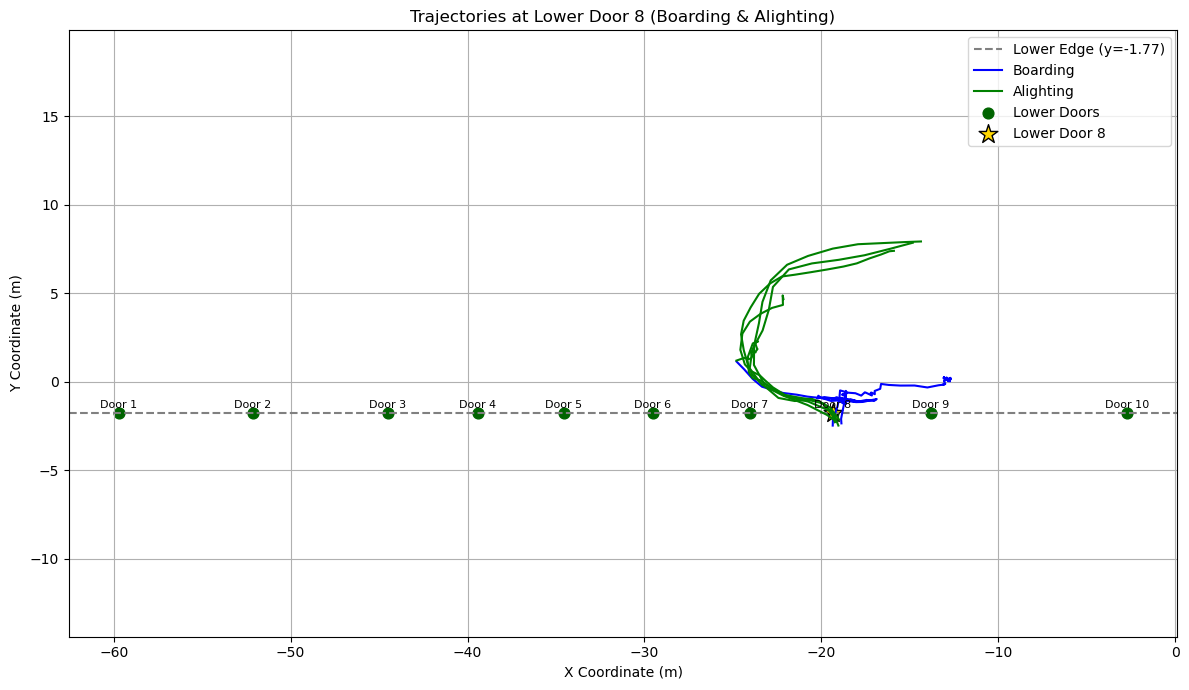

In [57]:
import matplotlib.pyplot as plt

# Step 1: Get IDs of passengers for Lower Door 8 (index 7 since it's 0-based)
door8_boarding_ids = [
    pid for pid, x_cross in boarding_lower if assign_door(x_cross, lower_doors) == 8
]

door8_alighting_ids = [
    pid for pid, x_cross in alighting_lower if assign_door(x_cross, lower_doors) == 8
]

# Step 2: Plot
plt.figure(figsize=(12, 7))

# Train edge line
plt.axhline(y=-1.77, color='gray', linestyle='--', label='Lower Edge (y=-1.77)')

# Plot boarding trajectories in blue
for pid in door8_boarding_ids:
    traj = agg_df[agg_df['id'] == pid]
    plt.plot(traj['x'], traj['y'], color='blue', label='Boarding' if pid == door8_boarding_ids[0] else "")

# Plot alighting trajectories in green
for pid in door8_alighting_ids:
    traj = agg_df[agg_df['id'] == pid]
    plt.plot(traj['x'], traj['y'], color='green', label='Alighting' if pid == door8_alighting_ids[0] else "")

# Mark all lower doors
plt.scatter(lower_doors, [-1.77] * len(lower_doors), c='darkgreen', s=60, label='Lower Doors')

# Highlight Lower Door 8
door8_x = lower_doors[7]
plt.scatter(door8_x, -1.77, c='gold', edgecolors='black', s=200, marker='*', label='Lower Door 8')

# Door labels
for i, x in enumerate(lower_doors):
    plt.text(x, -1.5, f'Door {i+1}', ha='center', fontsize=8)

# Styling
plt.title("Trajectories at Lower Door 8 (Boarding & Alighting)")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Y Coordinate (m)")
plt.axis('equal')
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


In [57]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Step 1: Manually enter data
combined_data = [
    {"boarding": 2, "alighting": 0, "time": 138},
    {"boarding": 2, "alighting": 0, "time": 23},
    {"boarding": 3, "alighting": 0, "time": 97},
    {"boarding": 2, "alighting": 0, "time": 122},
    {"boarding": 4, "alighting": 1, "time": 825},
    {"boarding": 5, "alighting": 2, "time": 302},
    {"boarding": 5, "alighting": 2, "time": 43},
    {"boarding": 10, "alighting": 7, "time": 457},
    {"boarding": 0, "alighting": 1, "time": 32},
    {"boarding": 8, "alighting": 8, "time": 157},
    {"boarding": 4, "alighting": 4, "time": 132},
    {"boarding": 21, "alighting": 4, "time": 775},
    {"boarding": 9, "alighting": 6, "time": 189},
    {"boarding": 11, "alighting": 6, "time": 551},
    {"boarding": 13, "alighting": 4, "time": 354},
    {"boarding": 9, "alighting": 8, "time": 534},
    {"boarding": 14, "alighting": 13, "time": 1043},
    {"boarding": 2, "alighting": 5, "time": 146},
    {"boarding": 5, "alighting": 4, "time": 254},
]

# Step 2: Create DataFrame
df = pd.DataFrame(combined_data)

# Step 3: Prepare features and target
X = df[["boarding", "alighting"]]
y = df["time"]

# Step 4: Fit model
model = LinearRegression()
model.fit(X, y)

# Step 5: Predict and extract coefficients
y_pred = model.predict(X)
a, b = model.coef_
c = model.intercept_

print(f"Regression Equation:")
print(f"Time (s) = {a:.2f} × Boarding + {b:.2f} × Alighting + {c:.2f}")

# Step 6: Evaluation Metrics
r2 = r2_score(y, y_pred)
mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

print("\n Model Evaluation Metrics:")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.2f} seconds")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} seconds")


Regression Equation:
Time (s) = 31.37 × Boarding + 19.32 × Alighting + 35.73

 Model Evaluation Metrics:
R² Score: 0.5239
Mean Absolute Error (MAE): 127.83 seconds
Root Mean Squared Error (RMSE): 199.44 seconds


In [ ]:
'''

Example: 2 boarding, 3 alighting 
Estimated dwell time: 156.43 seconds(2.61 minutes)

'''

In [35]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Step 1: Input data
combined_data = [
    {"boarding": 2, "alighting": 0, "time": 138},
    {"boarding": 2, "alighting": 0, "time": 23},
    {"boarding": 3, "alighting": 0, "time": 97},
    {"boarding": 2, "alighting": 0, "time": 122},
    {"boarding": 4, "alighting": 1, "time": 825},
    {"boarding": 5, "alighting": 2, "time": 302},
    {"boarding": 5, "alighting": 2, "time": 43},
    {"boarding": 10, "alighting": 7, "time": 457},
    {"boarding": 0, "alighting": 1, "time": 32},
    {"boarding": 8, "alighting": 8, "time": 157},
    {"boarding": 4, "alighting": 4, "time": 132},
    {"boarding": 21, "alighting": 4, "time": 775},
    {"boarding": 9, "alighting": 6, "time": 189},
    {"boarding": 11, "alighting": 6, "time": 551},
    {"boarding": 13, "alighting": 4, "time": 354},
    {"boarding": 9, "alighting": 8, "time": 534},
    {"boarding": 14, "alighting": 13, "time": 1043},
    {"boarding": 2, "alighting": 5, "time": 146},
    {"boarding": 5, "alighting": 4, "time": 254},
]

# Step 2: Create DataFrame
df = pd.DataFrame(combined_data)

# Step 3: Add quadratic features
df["boarding_sq"] = df["boarding"] ** 2
df["alighting_sq"] = df["alighting"] ** 2

# Step 4: Prepare features and target
X = df[["boarding", "alighting", "boarding_sq", "alighting_sq"]]
y = df["time"]

# Step 5: Fit model
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Step 6: Coefficients
a, b, c, d = model.coef_
e = model.intercept_
print(f" Regression Equation:")
print(f"Time (s) = {a:.2f} × Boarding + {b:.2f} × Alighting + {c:.2f} × Boarding² + {d:.2f} × Alighting² + {e:.2f}\n")

# Step 7: Evaluation Metrics
r2 = r2_score(y, y_pred)
mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

print("Model Performance Metrics:")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.2f} seconds")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} seconds")


 Regression Equation:
Time (s) = 40.65 × Boarding + -54.15 × Alighting + -0.20 × Boarding² + 6.33 × Alighting² + 105.00

Model Performance Metrics:
R² Score: 0.6241
Mean Absolute Error (MAE): 121.33 seconds
Root Mean Squared Error (RMSE): 177.22 seconds


In [ ]:
'''

Example: 2 boarding, 3 alighting
Estimated dwell time: 79.02 seconds(1.32 minutes)

'''